<br><font face="Times New Roman" size=5><div dir=ltr align=center>
<font color=blue size=8>
    Introduction to Machine Learning <br>
<font color=red size=5>
    Sharif University of Technology - Computer Engineering Department <br>
    Fall 2022<br> <br>
<font color=black size=6>
    Homework 2: Practical - Linear Regression
    </div>
<br><br>
<font size=4>
   **Name**: Mohammad Mahdi<br>
   **Student ID**: 98105557<br> <br>

<font face="Times New Roman" size=4><div dir=ltr>
# Problem 1: Linear Regression Model (40 + 30 optional points)
According to <a href="https://github.com/asharifiz/Introduction_to_Machine_Learning/blob/main/Jupyter_Notebooks/Chapter_02_Classical_Models/Linear%20regression.ipynb"><font face="Roboto">Linear Regression Notebook</font></a>, train a linear regression model on an arbitrary dataset. Explain your chosen dataset and split your data into train and test sets, then predict values for the test set using your trained model. Try to find the best hyperparameters for your model. (Using Lasso Regression, Ridge Regression or Elastic Net and comparing them will have extra optional points)
<br> Explain each step of your workflow.

In [47]:
# libraries
import pandas as pd
import numpy as np
import tqdm
from sklearn.model_selection import train_test_split
from sklearn import linear_model
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

### loading dataset
This dataset is Tesla's stock from 2010 to 2020. it has some columns of opening price or highest and lowest price of the day. we try to predict closing/the last price of the stock based on the other features.


In [72]:
df = pd.read_csv('TSLA.csv')
df.head()

,Date,Open,High,Low,Close,Adj Close,Volume
0,2010-06-29,19.000000,25.00,17.540001,23.889999,23.889999,18766300
1,2010-06-30,25.790001,30.42,23.299999,23.830000,23.830000,17187100
2,2010-07-01,25.000000,25.92,20.270000,21.959999,21.959999,8218800
3,2010-07-02,23.000000,23.10,18.709999,19.200001,19.200001,5139800
4,2010-07-06,20.000000,20.00,15.830000,16.110001,16.110001,6866900


In [73]:
df = df.drop(['Date'],axis=1)
y = df["Close"]
# y = np.log(y)
X = df.drop(["Close","Adj Close", "Volume"], axis=1)
X = X.to_numpy()
y = y.to_numpy()
y = y[:, np.newaxis]
y = (y - np.mean(y)) / np.std(y)


### Split dataset to train and test

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

### Regression mdoel closed form

In [75]:
class RegressionCloseForm:
    def __init__(self):
        self.W = None
              
    def train(self, X_train, y):
        X = np.append(np.ones((X_train.shape[0], 1)), X_train , axis=1)
        self.W = np.dot((np.linalg.inv(np.dot(X.T,X))), np.dot(X.T,y))
    
    def predict(self, X_test):
        X = np.append(np.ones((X_test.shape[0], 1)), X_test , axis=1)
        return np.dot(X, self.W)
    
    def mse_loss(self, pred, real):
        diff = pred - real
        return np.sum(diff * diff) / diff.size

In [76]:
model = RegressionCloseForm()
model.train(X_train, y_train)
predictions = model.predict(X_test)
model.mse_loss(y_test, predictions)

0.000305620436786433

### Vanilla Linear regression with sklearn

In [77]:
regr_model = linear_model.LinearRegression()
regr_model.fit(X_train, y_train)

LinearRegression()

MSE error on training data

In [78]:
predictions_train = regr_model.predict(X_train)
mean_squared_error(y_train, predictions_train)

0.0002870314506153462

MSE error on test data

In [79]:
predictions = regr_model.predict(X_test)
mean_squared_error(y_test, predictions)

0.0003056204367855879

In [80]:
# Evaluation of model regression score function. it shows our model works well
regr_model.score(X_test, y_test)

0.9997146194870747

Compare predicted values with real ones

In [81]:
comparison = pd.DataFrame({'Predicted':predictions.flatten(),'Real':y_test.flatten(), 'differnece':np.abs(predictions - y_test).flatten()})
comparison

,Predicted,Real,differnece
0,-1.301318,-1.300578,0.000740
1,-1.359250,-1.358004,0.001247
2,0.776619,0.783774,0.007155
3,1.210343,1.190452,0.019891
4,0.635803,0.612170,0.023634
...,...,...,...
479,-0.097015,-0.062157,0.034858
480,0.572415,0.549539,0.022876
481,-1.356143,-1.354561,0.001582
482,1.299261,1.337037,0.037776


So it seems that our model worked well.

### regression model from scratch

In [88]:
class RegressionModel:
    
    def __init__(self, lr, number_of_epochs, regularization=None):
        self.m = None # samples
        self.n = None # features
        self.W = None # weight
        self.regularization = regularization # penalty object
        self.lr = lr # learning rate
        self.epoch = number_of_epochs # iteration
        
    def __calculate_cost(self, y, y_pred):
        cost = (1 / (2 * self.m)) * np.sum(np.square(y_pred-y))
        if self.regularization:
            return cost + self.regularization(self.W) 
        return cost
    
    def __initialize(self, X):
        X2 = np.insert(X, 0, 1, axis=1)
        self.m, self.n = X2.shape
        self.W = np.random.rand(self.n, 1)
        return X2
    
    def __update_weights(self, X, y, y_pred):
        dw = np.dot(X.T, (y_pred - y)) / self.m
        if self.regularization:
            dw += self.regularization.derivation(self.W)
        
        self.W -= self.lr * dw
    
    def __feature_scaling(self, data):
        data2 = data.copy()
        number_of_columns = data.shape[1]
        for i in range(number_of_columns):
            data2[:,i] = (data2[:,i] - np.mean(data2[:,i])) / np.std(data2[:,i])
        return data2
        
    def fit(self, X_train, y_train, logging=True):
        if isinstance(X_train, pd.core.frame.DataFrame):
            X_train = X_train.to_numpy()
        if isinstance(y_train, pd.core.frame.DataFrame):
            y_train = y_train.to_numpy()
        X = self.__feature_scaling(X_train)
        
        X = self.__initialize(X)
        y = y_train.reshape(self.m, -1)
        for e in range(1, self.epoch+1):
            y_pred = np.dot(X, self.W)
            cost = self.__calculate_cost(y, y_pred)
            self.__update_weights(X, y, y_pred)
            if logging and e % 2000 == 0:
                print(f"The Cost in iteration {e}-----> {cost} :)")

    def predict(self, X_test):
        if isinstance(X_test, pd.core.frame.DataFrame):
            X_test = X_test.to_numpy()
        X_test2 = self.__feature_scaling(X_test)
        X_test2 = np.insert(X_test2, 0 , 1, axis= 1)
        return np.dot(X_test2, self.W) 

In [89]:
def mse_loss(pred, real):
    diff = pred - real
    return np.sum(diff * diff) / diff.size

In [84]:
# X_np = X.to_numpy()
# y_np = y.to_numpy()
# y_np = y_np[:, np.newaxis]

# X_train, X_test, y_train, y_test = train_test_split(X_np, y_np, test_size=0.2, random_state=42)
def feature_scaling_for_dependent_variable(variables):
    variables = (variables - int(np.mean(variables)))/np.std(variables)
    return variables


In [70]:
y_training_np = (y_train - np.mean(y)) / np.std(y)
reg_model_custom = RegressionModel(lr=0.1, number_of_epochs=50000)
reg_model_custom.fit(X_train, y_training_np)
predictions = reg_model_custom.predict(X_test)
predictions = (predictions * np.std(y)) + np.mean(y)
mse_loss(y_test, predictions)

1.4179382950486277
0.7704246428927173
0.438752842212676
0.2646086762123548
0.16987699462261743
0.11585107520690528
0.08322003312463448
0.06224435272745529
0.04792810310566561
0.037642653117707814
0.02995389531975694
0.024040905522051074
0.019405734316023934
0.015726899139166434
0.01278412194507421
0.010418644155251459
0.008511511137166552
0.006971094698660573
0.005725492043488375
0.004717597138477059
0.00390171054290562
0.0032410884578936974
0.0027061020967837704
0.0022728176721974486
0.0019218809365060072
0.0016376306931682777
0.0014073890900965804
0.0012208908497251803
0.0010698229513205206
0.0009474527568929592
0.0008483272751312214
0.0007680298014203381
0.0007029829120473621
0.0006502889462643128
0.0006076008245788755
0.0005730174252060043
0.0005449988456776213
0.0005222977680226586
0.0005039038661687504
0.0004889987767247308
0.0004769196257002789
0.000467129485337943
0.00045919344423977744
0.0004527592242153547
0.00044754147995092447
0.0004433090817523507
0.0004398748145722412
0.0

0.0003992786444644686
0.0003992499889720059
0.0003992213368365063
0.0003991926880575553
0.00039916404263473643
0.00039913540056763533
0.0003991067618558361
0.000399078126498924
0.0003990494944964836
0.0003990208658480998
0.0003989922405533576
0.00039896361861184204
0.0003989350000231385
0.0003989063847868314
0.00039887777290250644
0.00039884916436974855
0.0003988205591881437
0.0003987919573572761
0.000398763358876732
0.0003987347637460964
0.00039870617196495516
0.00039867758353289345
0.0003986489984494971
0.0003986204167143519
0.000398591838327043
0.00039856326328715683
0.00039853469159427873
0.0003985061232479949
0.0003984775582478913
0.0003984489965935532
0.00039842043828456725
0.0003983918833205197
0.0003983633317009965
0.0003983347834255834
0.0003983062384938674
0.00039827769690543424
0.0003982491586598702
0.0003982206237567622
0.0003981920921956964
0.00039816356397625924
0.0003981350390980376
0.0003981065175606176
0.00039807799936358623
0.0003980494845065304
0.00039802097298903647

0.0003730505800871504
0.00037302498755427605
0.00037299939800035023
0.00037297381142500566
0.0003729482278278766
0.0003729226472085959
0.00037289706956679744
0.0003728714949021149
0.00037284592321418155
0.0003728203545026315
0.0003727947887670978
0.0003727692260072148
0.0003727436662226161
0.0003727181094129358
0.0003726925555778078
0.00037266700471686554
0.00037264145682974347
0.00037261591191607593
0.00037259036997549643
0.0003725648310076392
0.00037253929501213876
0.00037251376198862914
0.0003724882319367446
0.0003724627048561196
0.0003724371807463886
0.00037241165960718556
0.0003723861414381455
0.0003723606262389029
0.0003723351140090921
0.00037230960474834784
0.0003722840984563045
0.00037225859513259716
0.0003722330947768604
0.00037220759738872946
0.00037218210296783845
0.0003721566115138229
0.0003721311230263173
0.00037210563750495677
0.0003720801549493767
0.000372054675359212
0.0003720291987340976
0.00037200372507366873
0.00037197825437756065
0.0003719527866454088
0.000371927321

0.00034929767450779785
0.00034927483791466935
0.00034925200396227504
0.00034922917265029163
0.00034920634397839586
0.0003491835179462649
0.0003491606945535757
0.00034913787380000524
0.00034911505568523067
0.00034909224020892904
0.0003490694273707774
0.00034904661717045346
0.0003490238096076339
0.00034900100468199626
0.00034897820239321797
0.00034895540274097644
0.0003489326057249486
0.0003489098113448123
0.0003488870196002449
0.0003488642304909241
0.0003488414440165274
0.00034881866017673227
0.0003487958789712166
0.00034877310039965786
0.00034875032446173406
0.00034872755115712294
0.0003487047804855021
0.00034868201244654944
0.0003486592470399431
0.00034863648426536114
0.00034861372412248095
0.0003485909666109814
0.00034856821173053973
0.0003485454594808343
0.00034852270986154377
0.0003484999628723456
0.0003484772185129185
0.00034845447678294087
0.00034843173768209077
0.0003484090012100463
0.00034838626736648654
0.00034836353615108937
0.00034834080756353345
0.0003483180816034975
0.0003

0.00032850316488627717
0.0003284827252577662
0.0003284622879775124
0.000328441853045229
0.00032842142046063123
0.0003284009902234325
0.00032838056233334804
0.0003283601367900922
0.000328339713593379
0.0003283192927429235
0.0003282988742384397
0.0003282784580796429
0.0003282580442662471
0.0003282376327979674
0.00032821722367451815
0.0003281968168956142
0.00032817641246097066
0.0003281560103703019
0.00032813561062332275
0.00032811521321974885
0.00032809481815929424
0.0003280744254416742
0.0003280540350666039
0.0003280336470337982
0.00032801326134297205
0.00032799287799384087
0.00032797249698611957
0.0003279521183195234
0.00032793174199376754
0.0003279113680085672
0.0003278909963636381
0.0003278706270586949
0.0003278502600934534
0.00032782989546762894
0.00032780953318093666
0.00032778917323309225
0.00032776881562381153
0.0003277484603528095
0.000327728107419802
0.0003277077568245048
0.00032768740856663333
0.000327667062645903
0.00032764671906203036
0.00032762637781473037
0.000327606038903

0.0003098663977226826
0.0003098480923757354
0.00030982978911812384
0.0003098114879495948
0.00030979318886989584
0.0003097748918787743
0.00030975659697597766
0.0003097383041612531
0.00030972001343434856
0.0003097017247950107
0.00030968343824298763
0.00030966515377802686
0.0003096468713998759
0.0003096285911082822
0.0003096103129029936
0.0003095920367837577
0.00030957376275032216
0.000309555490802435
0.00030953722093984354
0.0003095189531622959
0.00030950068746953983
0.0003094824238613231
0.0003094641623373937
0.0003094459028974997
0.0003094276455413889
0.0003094093902688093
0.00030939113707950883
0.0003093728859732357
0.0003093546369497382
0.0003093363900087641
0.00030931814515006156
0.000309299902373379
0.0003092816616784644
0.000309263423065066
0.00030924518653293264
0.00030922695208181195
0.0003092087197114525
0.00030919048942160295
0.0003091722612120113
0.0003091540350824261
0.0003091358110325959
0.0003091175890622694
0.0003090993691711947
0.0003090811513591209
0.000309062935625796


0.00029358050244542526
0.0002935640501114535
0.0002935475996433243
0.00029353115104081314
0.00029351470430369613
0.0002934982594317484
0.00029348181642474585
0.00029346537528246425
0.0002934489360046795
0.00029343249859116715
0.0002934160630417031
0.0002933996293560634
0.0002933831975340237
0.0002933667675753599
0.000293350339479848
0.00029333391324726395
0.0002933174888773839
0.00029330106636998393
0.00029328464572483964
0.0002932682269417274
0.0002932518100204234
0.0002932353949607036
0.00029321898176234415
0.00029320257042512164
0.00029318616094881186
0.00029316975333319094
0.0002931533475780356
0.00029313694368312214
0.0002931205416482264
0.00029310414147312513
0.0002930877431575947
0.0002930713467014114
0.0002930549521043516
0.0002930385593661921
0.0002930221684867094
0.0002930057794656796
0.0002929893923028797
0.00029297300699808584
0.0002929566235510753
0.0002929402419616241
0.00029292386222950904
0.000292907484354507
0.00029289110833639464
0.0002928747341749489
0.00029285836186

0.0002786869647956831
0.00027867219611261496
0.0002786574290935167
0.0002786426637381898
0.0002786279000464352
0.0002786131380180541
0.00027859837765284776
0.0002785836189506171
0.0002785688619111637
0.0002785541065342885
0.0002785393528197928
0.00027852460076747797
0.00027850985037714557
0.00027849510164859657
0.0002784803545816325
0.0002784656091760548
0.00027845086543166494
0.00027843612334826445
0.0002784213829256543
0.00027840664416363647
0.0002783919070620123
0.0002783771716205835
0.00027836243783915137
0.000278347705717518
0.00027833297525548445
0.00027831824645285227
0.00027830351930942406
0.0002782887938250005
0.00027827406999938396
0.00027825934783237585
0.00027824462732377813
0.00027822990847339255
0.0002782151912810207
0.00027820047574646494
0.0002781857618695266
0.0002781710496500079
0.0002781563390877107
0.0002781416301824369
0.00027812692293398885
0.00027811221734216766
0.00027809751340677623
0.00027808281112761605
0.0002780681105044897
0.0002780534115371987
0.0002780387

0.00026536600916150576
0.000265352736534239
0.0002653394653926413
0.00026532619573653644
0.0002653129275657478
0.00026529966088009916
0.00026528639567941333
0.0002652731319635149
0.00026525986973222667
0.00026524660898537256
0.00026523334972277626
0.0002652200919442613
0.0002652068356496516
0.0002651935808387705
0.0002651803275114421
0.0002651670756674898
0.0002651538253067378
0.00026514057642900953
0.0002651273290341288
0.00026511408312191955
0.0002651008386922059
0.00026508759574481123
0.00026507435427955975
0.0002650611142962755
0.0002650478757947821
0.00026503463877490383
0.00026502140323646445
0.0002650081691792884
0.0002649949366031989
0.0002649817055080208
0.0002649684758935777
0.000264955247759694
0.00026494202110619356
0.00026492879593290085
0.0002649155722396399
0.00026490235002623463
0.00026488912929250967
0.000264875910038289
0.0002648626922633969
0.0002648494759676578
0.00026483626115089595
0.00026482304781293544
0.0002648098359536009
0.0002647966255727166
0.00026478341667

0.00025364133376281814
0.00025362936942284605
0.00025361740641355925
0.00025360544473480097
0.00025359348438641405
0.0002535815253682414
0.0002535695676801256
0.00025355761132190977
0.00025354565629343717
0.0002535337025945504
0.0002535217502250925
0.0002535097991849063
0.0002534978494738351
0.0002534859010917222
0.0002534739540384101
0.00025346200831374214
0.00025345006391756114
0.00025343812084971086
0.0002534261791100338
0.00025341423869837333
0.0002534022996145729
0.0002533903618584753
0.0002533784254299241
0.0002533664903287623
0.0002533545565548331
0.0002533426241079799
0.000253330692988046
0.0002533187631948748
0.00025330683472830955
0.0002532949075881935
0.00025328298177437026
0.0002532710572866829
0.0002532591341249751
0.00025324721228909007
0.00025323529177887177
0.000253223372594163
0.00025321145473480763
0.00025319953820064915
0.00025318762299153096
0.0002531757091072967
0.0002531637965477899
0.00025315188531285435
0.0002531399754023333
0.0002531280668160706
0.0002531161595

0.00024300419084507746
0.00024299340584820945
0.00024298262204316314
0.000242971839429799
0.00024296105800797685
0.0002429502777775569
0.00024293949873839928
0.0002429287208903642
0.0002429179442333118
0.0002429071687671023
0.00024289639449159603
0.00024288562140665321
0.00024287484951213394
0.00024286407880789865
0.00024285330929380754
0.000242842540969721
0.00024283177383549944
0.0002428210078910029
0.0002428102431360922
0.00024279947957062735
0.00024278871719446887
0.0002427779560074771
0.0002427671960095127
0.0002427564372004358
0.0002427456795801072
0.00024273492314838712
0.00024272416790513634
0.000242713413850215
0.000242702660983484
0.00024269190930480383
0.00024268115881403464
0.00024267040951103758
0.00024265966139567314
0.00024264891446780168
0.00024263816872728406
0.00024262742417398083
0.00024261668080775275
0.0002426059386284607
0.00024259519763596482
0.00024258445783012636
0.00024257371921080587
0.00024256298177786418
0.00024255224553116194
0.00024254151047056017
0.00024

0.00023338324892177456
0.00023337352375184662
0.00023336379964971647
0.00023335407661525935
0.00023334435464835096
0.00023333463374886662
0.0002333249139166819
0.000233315195151672
0.00023330547745371294
0.0002332957608226799
0.00023328604525844863
0.00023327633076089446
0.00023326661732989305
0.0002332569049653201
0.00023324719366705118
0.00023323748343496178
0.0002332277742689276
0.00023321806616882448
0.000233208359134528
0.0002331986531659136
0.00023318894826285732
0.0002331792444252346
0.00023316954165292133
0.00023315983994579327
0.00023315013930372597
0.00023314043972659564
0.00023313074121427752
0.00023312104376664786
0.00023311134738358236
0.00023310165206495668
0.00023309195781064693
0.00023308226462052868
0.00023307257249447817
0.000233062881432371
0.00023305319143408326
0.00023304350249949066
0.00023303381462846947
0.00023302412782089557
0.0002330144420766447
0.00023300475739559292
0.00023299507377761634
0.0002329853912225911
0.000232975709730393
0.00023296602930089822
0.00

0.00022467858919159037
0.00022466981675001564
0.00022466104526544197
0.0002246522747377584
0.00022464350516685435
0.00022463473655261846
0.00022462596889494
0.0002246172021937083
0.00022460843644881218
0.000224599671660141
0.00022459090782758358
0.00022458214495102967
0.00022457338303036802
0.00022456462206548797
0.00022455586205627883
0.0002245471030026295
0.0002245383449044296
0.0002245295877615681
0.00022452083157393425
0.00022451207634141768
0.00022450332206390728
0.00022449456874129266
0.00022448581637346304
0.00022447706496030764
0.00022446831450171595
0.00022445956499757727
0.0002244508164477809
0.00022444206885221648
0.0002244333222107732
0.00022442457652334047
0.0002244158317898078
0.00022440708801006477
0.00022439834518400055
0.0002243896033115046
0.00022438086239246673
0.00022437212242677618
0.0002243633834143226
0.00022435464535499542
0.0002243459082486842
0.00022433717209527845
0.00022432843689466794
0.0002243197026467419
0.00022431096935139033
0.0002243022370085025
0.0002

0.00021662642981972182
0.00021661853296615495
0.00021661063696841288
0.00021660274182639714
0.00021659484754000906
0.00021658695410914995
0.00021657906153372148
0.0002165711698136251
0.0002165632789487623
0.00021655538893903455
0.0002165474997843434
0.0002165396114845904
0.00021653172403967704
0.00021652383744950472
0.00021651595171397542
0.0002165080668329905
0.00021650018280645154
0.00021649229963426
0.0002164844173163177
0.00021647653585252618
0.0002164686552427871
0.00021646077548700225
0.00021645289658507298
0.00021644501853690127
0.00021643714134238855
0.00021642926500143678
0.00021642138951394755
0.0002164135148798225
0.00021640564109896366
0.00021639776817127234
0.00021638989609665046
0.00021638202487500008
0.00021637415450622257
0.00021636628499021994
0.00021635841632689412
0.00021635054851614662
0.00021634268155787953
0.00021633481545199458
0.0002163269501983936
0.00021631908579697852
0.00021631122224765115
0.00021630335955031364
0.00021629549770486745
0.0002162876367112146
0

0.0002092333856251842
0.0002092262873712301
0.0002092191898814276
0.0002092120931556892
0.00020920499719392774
0.0002091979019960555
0.00020919080756198538
0.0002091837138916298
0.00020917662098490143
0.0002091695288417132
0.00020916243746197725
0.00020915534684560664
0.00020914825699251387
0.00020914116790261172
0.0002091340795758127
0.00020912699201202978
0.0002091199052111755
0.00020911281917316277
0.00020910573389790408
0.0002090986493853125
0.00020909156563530027
0.0002090844826477806
0.0002090774004226664
0.00020907031895987
0.0002090632382593044
0.00020905615832088255
0.00020904907914451692
0.00020904200073012093
0.00020903492307760692
0.00020902784618688787
0.00020902077005787673
0.00020901369469048631
0.00020900662008462953
0.00020899954624021915
0.00020899247315716836
0.00020898540083538983
0.00020897832927479676
0.00020897125847530172
0.00020896418843681776
0.00020895711915925818
0.00020895005064253564
0.00020894298288656307
0.00020893591589125364
0.00020892884965652034
0.00

0.00020277113842771656
0.0002027647336595495
0.00020275832957645227
0.00020275192617834694
0.0002027455234651558
0.00020273912143680084
0.00020273272009320445
0.00020272631943428845
0.0002027199194599753
0.0002027135201701872
0.0002027071215648463
0.0002027007236438747
0.00020269432640719468
0.00020268792985472849
0.00020268153398639833
0.00020267513880212662
0.00020266874430183545
0.00020266235048544724
0.00020265595735288413
0.0002026495649040684
0.00020264317313892233
0.00020263678205736856
0.00020263039165932897
0.00020262400194472595
0.00020261761291348208
0.00020261122456551953
0.00020260483690076063
0.0002025984499191279
0.00020259206362054357
0.00020258567800492995
0.00020257929307220972
0.000202572908822305
0.00020256652525513835
0.00020256014237063203
0.00020255376016870867
0.00020254737864929063
0.0002025409978123004
0.00020253461765766035
0.00020252823818529286
0.00020252185939512055
0.000202515481287066
0.00020250910386105145
0.0002025027271169996
0.00020249635105483292
0.

0.00019705413996020665
0.00019704834481995228
0.00019704255029569763
0.0001970367563873736
0.0001970309630949103
0.00019702517041823828
0.00019701937835728798
0.00019701358691198993
0.00019700779608227456
0.00019700200586807238
0.00019699621626931396
0.00019699042728592962
0.00019698463891784998
0.00019697885116500566
0.00019697306402732695
0.00019696727750474448
0.00019696149159718877
0.00019695570630459062
0.00019694992162688026
0.00019694413756398842
0.00019693835411584574
0.00019693257128238273
0.00019692678906352987
0.00019692100745921794
0.0001969152264693775
0.00019690944609393913
0.0001969036663328336
0.00019689788718599128
0.00019689210865334289
0.00019688633073481932
0.00019688055343035092
0.00019687477673986864
0.000196869000663303
0.0001968632252005847
0.00019685745035164445
0.0001968516761164129
0.00019684590249482075
0.00019684012948679896
0.0001968343570922779
0.0001968285853111886
0.00019682281414346156
0.00019681704358902777
0.00019681127364781786
0.0001968055043197625

0.00019177489390230078
0.00019176965818335555
0.00019176442301743925
0.00019175918840449015
0.00019175395434444602
0.00019174872083724473
0.00019174348788282442
0.00019173825548112318
0.00019173302363207877
0.0001917277923356293
0.00019172256159171266
0.0001917173314002672
0.0001917121017612306
0.00019170687267454099
0.0001917016441401366
0.0001916964161579551
0.00019169118872793475
0.0001916859618500138
0.00019168073552413003
0.00019167550975022148
0.00019167028452822646
0.000191665059858083
0.00019165983573972913
0.00019165461217310304
0.00019164938915814268
0.00019164416669478638
0.00019163894478297212
0.000191633723422638
0.00019162850261372226
0.00019162328235616314
0.00019161806264989865
0.00019161284349486705
0.0001916076248910063
0.00019160240683825484
0.0001915971893365507
0.00019159197238583208
0.00019158675598603735
0.00019158154013710444
0.00019157632483897172
0.0001915711100915775
0.00019156589589485986
0.00019156068224875715
0.00019155546915320749
0.00019155025660814922
0

0.00018724107406441215
0.00018723631584114517
0.0001872315581175022
0.00018722680089342748
0.00018722204416886544
0.00018721728794376044
0.00018721253221805665
0.00018720777699169852
0.0001872030222646303
0.00018719826803679636
0.00018719351430814102
0.0001871887610786086
0.0001871840083481435
0.00018717925611669013
0.0001871745043841928
0.00018716975315059603
0.00018716500241584388
0.0001871602521798811
0.00018715550244265177
0.00018715075320410057
0.00018714600446417172
0.00018714125622280967
0.000187136508479959
0.00018713176123556394
0.0001871270144895689
0.0001871222682419185
0.00018711752249255716
0.00018711277724142914
0.00018710803248847915
0.0001871032882336516
0.00018709854447689095
0.00018709380121814147
0.00018708905845734802
0.00018708431619445486
0.00018707957442940635
0.0001870748331621474
0.00018707009239262224
0.00018706535212077545
0.00018706061234655163
0.00018705587306989512
0.00018705113429075076
0.00018704639600906277
0.00018704165822477594
0.00018703692093783485


0.00018291672827297904
0.00018291242274270719
0.00018290811766175143
0.00018290381303006202
0.0001828995088475894
0.00018289520511428372
0.00018289090183009498
0.00018288659899497403
0.0001828822966088704
0.00018287799467173483
0.00018287369318351757
0.00018286939214416875
0.00018286509155363863
0.00018286079141187778
0.00018285649171883632
0.00018285219247446438
0.00018284789367871255
0.00018284359533153103
0.00018283929743287015
0.00018283499998268026
0.00018283070298091158
0.00018282640642751458
0.00018282211032243957
0.00018281781466563692
0.0001828135194570569
0.00018280922469665
0.00018280493038436643
0.00018280063652015687
0.00018279634310397122
0.00018279205013576032
0.00018278775761547427
0.0001827834655430636
0.00018277917391847884
0.00018277488274167007
0.000182770592012588
0.00018276630173118293
0.0001827620118974051
0.00018275772251120527
0.00018275343357253382
0.00018274914508134107
0.00018274485703757745
0.00018274056944119353
0.00018273628229213974
0.0001827319955903666

0.00017902992084449024
0.00017902601973213014
0.0001790221190244364
0.00017901821872136418
0.00017901431882286938
0.0001790104193289071
0.00017900652023943308
0.00017900262155440256
0.00017899872327377137
0.00017899482539749474
0.00017899092792552818
0.00017898703085782755
0.00017898313419434795
0.00017897923793504505
0.00017897534207987452
0.00017897144662879159
0.00017896755158175196
0.0001789636569387113
0.00017895976269962505
0.0001789558688644487
0.00017895197543313786
0.0001789480824056482
0.00017894418978193515
0.00017894029756195432
0.00017893640574566117
0.00017893251433301157
0.00017892862332396096
0.00017892473271846477
0.00017892084251647884
0.00017891695271795874
0.00017891306332286014
0.00017890917433113827
0.00017890528574274913
0.00017890139755764837
0.0001788975097757914
0.00017889362239713395
0.00017888973542163163
0.00017888584884924019
0.0001788819626799153
0.00017887807691361232
0.00017887419155028728
0.0001788703065898957
0.00017886642203239324
0.00017886253787773

0.00017557444704378462
0.00017557090334570846
0.0001755673600130914
0.00017556381704589361
0.00017556027444407508
0.00017555673220759585
0.00017555319033641604
0.0001755496488304955
0.0001755461076897946
0.00017554256691427336
0.00017553902650389156
0.00017553548645860955
0.00017553194677838728
0.00017552840746318506
0.00017552486851296267
0.00017552132992768033
0.00017551779170729828
0.00017551425385177636
0.00017551071636107504
0.00017550717923515397
0.00017550364247397358
0.00017550010607749416
0.00017549657004567543
0.00017549303437847753
0.0001754894990758611
0.0001754859641377857
0.00017548242956421184
0.00017547889535509968
0.0001754753615104091
0.00017547182803010037
0.00017546829491413385
0.00017546476216246952
0.0001754612297750675
0.00017545769775188826
0.0001754541660928916
0.00017545063479803796
0.00017544710386728748
0.0001754435733006003
0.00017544004309793664
0.00017543651325925688
0.00017543298378452105
0.00017542945467368935
0.0001754259259267222
0.0001754223975435795

0.000172341432821386
0.00017233822157424836
0.00017233501065633556
0.00017233180006761206
0.00017232858980804197
0.00017232537987758956
0.00017232217027621908
0.0001723189610038948
0.00017231575206058113
0.00017231254344624196
0.00017230933516084186
0.00017230612720434515
0.00017230291957671582
0.00017229971227791837
0.00017229650530791693
0.00017229329866667582
0.00017229009235415947
0.00017228688637033215
0.000172283680715158
0.0001722804753886013
0.00017227727039062664
0.000172274065721198
0.00017227086138027999
0.0001722676573678368
0.00017226445368383268
0.000172261250328232
0.00017225804730099914
0.0001722548446020984
0.0001722516422314942
0.0001722484401891507
0.00017224523847503243
0.00017224203708910362
0.00017223883603132884
0.0001722356353016721
0.00017223243490009798
0.00017222923482657096
0.00017222603508105502
0.00017222283566351504
0.000172219636573915
0.00017221643781221952
0.00017221323937839292
0.00017221004127239946
0.0001722068434942038
0.00017220364604377008
0.0001

0.00016934690427775827
0.00016934399914187755
0.00016934109430207758
0.0001693381897583267
0.00016933528551059263
0.00016933238155884361
0.00016932947790304758
0.00016932657454317272
0.00016932367147918704
0.00016932076871105866
0.0001693178662387555
0.0001693149640622459
0.0001693120621814977
0.0001693091605964791
0.00016930625930715825
0.00016930335831350304
0.00016930045761548188
0.00016929755721306253
0.00016929465710621328
0.0001692917572949023
0.0001692888577790976
0.0001692859585587672
0.00016928305963387948
0.0001692801610044023
0.00016927726267030398
0.00016927436463155256
0.00016927146688811617
0.00016926856943996296
0.00016926567228706113
0.00016926277542937882
0.00016925987886688397
0.0001692569825995451
0.00016925408662733004
0.00016925119095020707
0.00016924829556814436
0.00016924540048111016
0.00016924250568907238
0.00016923961119199942
0.00016923671698985948
0.00016923382308262077
0.00016923092947025126
0.00016922803615271914
0.0001692251431299928
0.00016922225040204048

0.0001667715153625413
0.00016676887198823406
0.00016676622888184815
0.00016676358604335472
0.0001667609434727251
0.00016675830116993066
0.00016675565913494244
0.00016675301736773196
0.00016675037586827047
0.00016674773463652915
0.00016674509367247932
0.00016674245297609242
0.00016673981254733964
0.0001667371723861922
0.00016673453249262137
0.00016673189286659873
0.00016672925350809536
0.00016672661441708274
0.00016672397559353212
0.00016672133703741468
0.0001667186987487019
0.0001667160607273651
0.0001667134229733756
0.0001667107854867046
0.00016670814826732372
0.00016670551131520403
0.0001667028746303171
0.0001667002382126341
0.00016669760206212633
0.00016669496617876538
0.00016669233056252245
0.00016668969521336897
0.00016668706013127634
0.00016668442531621576
0.00016668179076815873
0.0001666791564870765
0.00016667652247294066
0.00016667388872572246
0.00016667125524539325
0.0001666686220319244
0.00016666598908528742
0.00016666335640545376
0.00016666072399239458
0.00016665809184608136

0.0001643027680829133
0.00016430037422764614
0.00016429798061362932
0.00016429558724083683
0.00016429319410924333
0.00016429080121882267
0.00016428840856954946
0.00016428601616139794
0.00016428362399434246
0.00016428123206835713
0.00016427884038341665
0.00016427644893949505
0.00016427405773656678
0.00016427166677460603
0.00016426927605358736
0.00016426688557348492
0.00016426449533427304
0.00016426210533592613
0.00016425971557841847
0.00016425732606172456
0.0001642549367858186
0.000164252547750675
0.00016425015895626808
0.00016424777040257218
0.00016424538208956182
0.00016424299401721106
0.00016424060618549442
0.0001642382185943865
0.00016423583124386136
0.0001642334441338934
0.00016423105726445713
0.00016422867063552678
0.00016422628424707695
0.0001642238980990819
0.00016422151219151602
0.00016421912652435364
0.00016421674109756915
0.00016421435591113713
0.00016421197096503184
0.00016420958625922767
0.00016420720179369914
0.00016420481756842048
0.00016420243358336624
0.0001642000498385

0.00016226036329183524
0.00016225817475238048
0.00016225598643236625
0.00016225379833176943
0.0001622516104505667
0.0001622494227887348
0.0001622472353462505
0.0001622450481230907
0.0001622428611192321
0.00016224067433465132
0.00016223848776932532
0.00016223630142323092
0.0001622341152963448
0.0001622319293886437
0.0001622297437001045
0.00016222755823070393
0.00016222537298041885
0.000162223187949226
0.00016222100313710225
0.00016221881854402436
0.0001622166341699691
0.00016221445001491332
0.00016221226607883378
0.00016221008236170736
0.00016220789886351076
0.00016220571558422104
0.00016220353252381474
0.0001622013496822688
0.00016219916705956006
0.00016219698465566533
0.00016219480247056154
0.0001621926205042253
0.00016219043875663366
0.00016218825722776335
0.00016218607591759123
0.00016218389482609418
0.00016218171395324894
0.00016217953329903244
0.00016217735286342156
0.00016217517264639308
0.0001621729926479239
0.0001621708128679909
0.0001621686333065709
0.00016216645396364073
0.00

0.00016022923522448547
0.00016022724979783875
0.00016022526456918896
0.00016022327953851546
0.00016022129470579741
0.00016021931007101405
0.00016021732563414437
0.00016021534139516744
0.00016021335735406277
0.00016021137351080933
0.0001602093898653863
0.000160207406417773
0.00016020542316794853
0.00016020344011589204
0.00016020145726158274
0.00016019947460499978
0.00016019749214612246
0.00016019550988492993
0.00016019352782140148
0.00016019154595551608
0.00016018956428725308
0.00016018758281659168
0.00016018560154351113
0.0001601836204679906
0.00016018163959000925
0.00016017965890954638
0.00016017767842658114
0.00016017569814109287
0.00016017371805306056
0.00016017173816246374
0.0001601697584692814
0.00016016777897349287
0.00016016579967507733
0.00016016382057401407
0.00016016184167028224
0.00016015986296386115
0.0001601578844547301
0.0001601559061428682
0.00016015392802825484
0.00016015195011086903
0.0001601499723906902
0.00016014799486769774
0.00016014601754187063
0.00016014404041318

0.00015855997382422087
0.00015855815447231474
0.00015855633530097805
0.00015855451631019202
0.00015855269749993765
0.00015855087887019627
0.00015854906042094886
0.0001585472421521766
0.0001585454240638605
0.0001585436061559817
0.00015854178842852142
0.00015853997088146067
0.00015853815351478062
0.00015853633632846231
0.0001585345193224871
0.0001585327024968359
0.00015853088585148994
0.00015852906938643038
0.00015852725310163817
0.00015852543699709478
0.00015852362107278097
0.0001585218053286782
0.00015851998976476752
0.00015851817438102998
0.0001585163591774468
0.00015851454415399918
0.00015851272931066823
0.000158510914647435
0.00015850910016428093
0.00015850728586118686
0.0001585054717381342
0.00015850365779510387
0.00015850184403207719
0.00015850003044903536
0.00015849821704595963
0.00015849640382283086
0.00015849459077963047
0.00015849277791633968
0.00015849096523293946
0.00015848915272941112
0.00015848734040573587
0.00015848552826189493
0.0001584837162978692
0.0001584819045136403


0.0001568921562097237
0.00015689050197065747
0.00015688884789493628
0.00015688719398254325
0.0001568855402334613
0.0001568838866476734
0.00015688223322516269
0.00015688057996591202
0.00015687892686990456
0.00015687727393712335
0.00015687562116755132
0.00015687396856117145
0.0001568723161179669
0.00015687066383792076
0.00015686901172101594
0.00015686735976723539
0.00015686570797656242
0.00015686405634897968
0.00015686240488447053
0.00015686075358301794
0.0001568591024446049
0.00015685745146921446
0.00015685580065682964
0.00015685415000743383
0.00015685249952100948
0.00015685084919754024
0.0001568491990370086
0.0001568475490393981
0.00015684589920469163
0.00015684424953287207
0.00015684260002392277
0.0001568409506778266
0.0001568393014945667
0.00015683765247412614
0.00015683600361648798
0.00015683435492163536
0.00015683270638955121
0.00015683105802021875
0.0001568294098136209
0.000156827761769741
0.00015682611388856185
0.00015682446617006684
0.00015682281861423855
0.00015682117122106044


0.00015540396009765945
0.0001554024524541337
0.00015540094495875242
0.0001553994376115002
0.00015539793041236197
0.0001553964233613222
0.00015539491645836557
0.0001553934097034768
0.00015539190309664069
0.00015539039663784173
0.00015538889032706493
0.00015538738416429464
0.0001553858781495158
0.00015538437228271307
0.00015538286656387106
0.0001553813609929746
0.00015537985557000824
0.00015537835029495685
0.00015537684516780506
0.0001553753401885375
0.0001553738353571391
0.00015537233067359452
0.00015537082613788819
0.00015536932175000512
0.0001553678175099299
0.00015536631341764746
0.00015536480947314234
0.00015536330567639923
0.00015536180202740292
0.00015536029852613817
0.00015535879517258964
0.0001553572919667422
0.0001553557889085804
0.0001553542859980891
0.00015535278323525303
0.0001553512806200569
0.0001553497781524854
0.00015534827583252338
0.00015534677366015536
0.00015534527163536645
0.0001553437697581411
0.00015534226802846424
0.00015534076644632043
0.00015533926501169453
0.0

0.00015399109521876535
0.00015398972606701558
0.0001539883570491359
0.00015398698816511262
0.0001539856194149322
0.00015398425079858082
0.0001539828823160446
0.0001539815139673097
0.00015398014575236264
0.00015397877767118966
0.00015397740972377682
0.0001539760419101104
0.0001539746742301769
0.00015397330668396215
0.00015397193927145286
0.000153970571992635
0.0001539692048474951
0.0001539678378360191
0.00015396647095819335
0.00015396510421400442
0.00015396373760343825
0.00015396237112648125
0.00015396100478311958
0.0001539596385733397
0.00015395827249712775
0.00015395690655447
0.00015395554074535282
0.00015395417506976238
0.000153952809527685
0.00015395144411910715
0.0001539500788440149
0.0001539487137023945
0.0001539473486942324
0.00015394598381951468
0.0001539446190782279
0.00015394325447035825
0.00015394188999589184
0.0001539405256548153
0.00015393916144711467
0.00015393779737277627
0.00015393643343178645
0.0001539350696241316
0.00015393370594979784
0.00015393234240877165
0.00015393

0.00015274509293850905
0.00015274384533494652
0.00015274259785280086
0.0001527413504920594
0.00015274010325271002
0.00015273885613474003
0.00015273760913813732
0.00015273636226288941
0.00015273511550898381
0.00015273386887640832
0.00015273262236515026
0.00015273137597519748
0.00015273012970653743
0.0001527288835591578
0.00015272763753304626
0.00015272639162819038
0.00015272514584457772
0.00015272390018219577
0.0001527226546410325
0.0001527214092210752
0.0001527201639223117
0.00015271891874472948
0.00015271767368831615
0.0001527164287530596
0.00015271518393894707
0.00015271393924596647
0.00015271269467410526
0.00015271145022335115
0.00015271020589369185
0.00015270896168511483
0.00015270771759760785
0.00015270647363115845
0.0001527052297857542
0.00015270398606138296
0.00015270274245803229
0.00015270149897568977
0.000152700255614343
0.00015269901237397964
0.00015269776925458752
0.0001526965262561541
0.00015269528337866694
0.00015269404062211387
0.00015269279798648248
0.0001526915554717603

0.00015164363728613814
0.00015164249664334335
0.00015164135611106844
0.00015164021568930206
0.00015163907537803318
0.00015163793517725046
0.0001516367950869426
0.0001516356551070986
0.00015163451523770693
0.00015163337547875662
0.00015163223583023648
0.00015163109629213504
0.00015162995686444116
0.0001516288175471439
0.00015162767834023163
0.00015162653924369348
0.00015162540025751814
0.00015162426138169425
0.00015162312261621073
0.0001516219839610563
0.00015162084541621996
0.0001516197069816902
0.0001516185686574559
0.00015161743044350608
0.00015161629233982935
0.00015161515434641447
0.00015161401646325036
0.00015161287869032577
0.00015161174102762938
0.0001516106034751502
0.00015160946603287693
0.00015160832870079842
0.0001516071914789034
0.00015160605436718077
0.00015160491736561919
0.0001516037804742077
0.00015160264369293487
0.00015160150702178975
0.00015160037046076097
0.00015159923400983742
0.00015159809766900786
0.0001515969614382611
0.0001515958253175862
0.00015159468930697165

0.0001506291186438636
0.0001506280760913376
0.00015062703363939308
0.00015062599128801962
0.00015062494903720722
0.0001506239068869458
0.0001506228648372252
0.00015062182288803506
0.00015062078103936534
0.00015061973929120592
0.0001506186976435464
0.00015061765609637715
0.00015061661464968752
0.00015061557330346765
0.00015061453205770714
0.000150613490912396
0.00015061244986752412
0.00015061140892308128
0.00015061036807905727
0.00015060932733544218
0.00015060828669222556
0.00015060724614939742
0.00015060620570694772
0.00015060516536486617
0.00015060412512314254
0.0001506030849817669
0.00015060204494072912
0.00015060100500001884
0.00015059996515962622
0.00015059892541954083
0.00015059788577975272
0.0001505968462402517
0.00015059580680102757
0.00015059476746207036
0.00015059372822336992
0.000150592689084916
0.00015059165004669846
0.00015059061110870735
0.00015058957227093243
0.00015058853353336357
0.00015058749489599066
0.00015058645635880358
0.0001505854179217922
0.0001505843795849465
0

0.00014967976752057146
0.00014967881636404883
0.000149677865298898
0.00014967691432510956
0.00014967596344267462
0.00014967501265158363
0.00014967406195182776
0.00014967311134339757
0.00014967216082628407
0.00014967121040047787
0.00014967026006597006
0.0001496693098227512
0.00014966835967081238
0.00014966740961014417
0.00014966645964073765
0.00014966550976258338
0.00014966455997567258
0.00014966361027999564
0.00014966266067554363
0.0001496617111623074
0.0001496607617402778
0.00014965981240944545
0.00014965886316980136
0.00014965791402133644
0.00014965696496404136
0.00014965601599790712
0.00014965506712292444
0.0001496541183390841
0.00014965316964637716
0.00014965222104479413
0.00014965127253432624
0.00014965032411496418
0.00014964937578669873
0.00014964842754952074
0.0001496474794034212
0.00014964653134839085
0.00014964558338442045
0.00014964463551150103
0.00014964368772962333
0.00014964274003877824
0.00014964179243895674
0.00014964084493014946
0.00014963989751234731
0.0001496389501855

0.00014881087230174365
0.00014881000444300017
0.00014880913666728016
0.00014880826897457534
0.00014880740136487736
0.000148806533838178
0.00014880566639446905
0.0001488047990337419
0.00014880393175598864
0.0001488030645612008
0.00014880219744936994
0.00014880133042048798
0.0001488004634745467
0.0001487995966115376
0.00014879872983145244
0.00014879786313428298
0.00014879699652002096
0.00014879612998865802
0.00014879526354018595
0.0001487943971745963
0.00014879353089188092
0.00014879266469203166
0.0001487917985750401
0.0001487909325408978
0.00014879006658959673
0.00014878920072112852
0.00014878833493548488
0.00014878746923265753
0.0001487866036126383
0.00014878573807541867
0.00014878487262099058
0.00014878400724934569
0.00014878314196047567
0.00014878227675437235
0.00014878141163102748
0.0001487805465904327
0.0001487796816325798
0.00014877881675746032
0.0001487779519650663
0.00014877708725538939
0.00014877622262842116
0.00014877535808415336
0.00014877449362257796
0.00014877362924368658
0

0.00014801396379834168
0.00014801317202316284
0.00014801238032342287
0.00014801158869911415
0.00014801079715022936
0.0001480100056767609
0.0001480092142787014
0.00014800842295604314
0.00014800763170877881
0.00014800684053690083
0.00014800604944040178
0.0001480052584192741
0.0001480044674735103
0.00014800367660310296
0.00014800288580804445
0.00014800209508832735
0.0001480013044439443
0.0001480005138748876
0.00014799972338115
0.00014799893296272358
0.00014799814261960142
0.00014799735235177558
0.0001479965621592389
0.00014799577204198364
0.00014799498200000234
0.00014799419203328777
0.0001479934021418322
0.00014799261232562817
0.00014799182258466828
0.0001479910329189451
0.00014799024332845105
0.00014798945381317864
0.0001479886643731203
0.0001479878750082688
0.00014798708571861664
0.00014798629650415612
0.00014798550736488006
0.0001479847183007806
0.00014798392931185053
0.00014798314039808248
0.00014798235155946877
0.0001479815627960019
0.00014798077410767467
0.00014797998549447925
0.00

0.00014728534234440736
0.00014728461985635388
0.0001472838974368681
0.00014728317508594328
0.00014728245280357268
0.00014728173058974948
0.00014728100844446686
0.00014728028636771818
0.00014727956435949658
0.00014727884241979514
0.00014727812054860745
0.00014727739874592638
0.00014727667701174528
0.00014727595534605735
0.0001472752337488559
0.00014727451222013406
0.00014727379075988515
0.00014727306936810236
0.00014727234804477887
0.00014727162678990788
0.00014727090560348266
0.0001472701844854967
0.0001472694634359427
0.00014726874245481433
0.00014726802154210468
0.0001472673006978069
0.00014726657992191443
0.0001472658592144203
0.00014726513857531788
0.00014726441800460034
0.00014726369750226093
0.00014726297706829284
0.0001472622567026894
0.0001472615364054438
0.00014726081617654922
0.0001472600960159991
0.00014725937592378644
0.0001472586558999047
0.00014725793594434696
0.0001472572160571065
0.00014725649623817654
0.00014725577648755036
0.00014725505680522125
0.0001472543371911826


0.000146601265367528
0.00014660060767666998
0.000146599950047987
0.00014659929248147298
0.00014659863497712175
0.00014659797753492743
0.0001465973201548834
0.0001465966628369841
0.00014659600558122301
0.00014659534838759442
0.0001465946912560919
0.00014659403418670948
0.0001465933771794408
0.00014659272023428003
0.0001465920633512211
0.00014659140653025768
0.00014659074977138367
0.00014659009307459314
0.00014658943643987976
0.00014658877986723772
0.00014658812335666067
0.00014658746690814254
0.00014658681052167726
0.0001465861541972588
0.00014658549793488088
0.00014658484173453754
0.00014658418559622259
0.00014658352951993004
0.0001465828735056536
0.00014658221755338733
0.00014658156166312498
0.00014658090583486073
0.00014658025006858826
0.00014657959436430146
0.00014657893872199428
0.00014657828314166072
0.00014657762762329448
0.00014657697216688965
0.00014657631677243992
0.00014657566143993958
0.00014657500616938214
0.00014657435096076152
0.0001465736958140719
0.00014657304072930716


0.0001459784298296575
0.00014597783090934923
0.0001459772320454477
0.00014597663323794705
0.000145976034486842
0.00014597543579212692
0.00014597483715379637
0.00014597423857184478
0.00014597364004626654
0.0001459730415770562
0.00014597244316420834
0.00014597184480771738
0.0001459712465075778
0.00014597064826378392
0.00014597005007633044
0.0001459694519452118
0.00014596885387042248
0.00014596825585195684
0.0001459676578898096
0.00014596705998397497
0.00014596646213444768
0.00014596586434122212
0.0001459652666042928
0.00014596466892365415
0.00014596407129930077
0.000145963473731227
0.00014596287621942741
0.00014596227876389648
0.00014596168136462882
0.0001459610840216187
0.0001459604867348608
0.00014595988950434952
0.00014595929233007925
0.00014595869521204482
0.00014595809815024045
0.00014595750114466065
0.00014595690419530008
0.00014595630730215297
0.00014595571046521405
0.00014595511368447768
0.00014595451695993849
0.0001459539202915909
0.00014595332367942944
0.00014595272712344856
0.

0.00014540951666939825
0.00014540897123329315
0.00014540842584837103
0.00014540788051462694
0.00014540733523205586
0.00014540679000065278
0.00014540624482041285
0.00014540569969133103
0.00014540515461340214
0.00014540460958662138
0.0001454040646109838
0.00014540351968648428
0.000145402974813118
0.00014540242999087989
0.00014540188521976498
0.00014540134049976814
0.0001454007958308846
0.00014540025121310938
0.00014539970664643757
0.0001453991621308637
0.00014539861766638338
0.00014539807325299127
0.0001453975288906826
0.0001453969845794524
0.00014539644031929543
0.00014539589611020705
0.00014539535195218204
0.00014539480784521563
0.00014539426378930255
0.00014539371978443822
0.00014539317583061733
0.00014539263192783506
0.0001453920880760864
0.00014539154427536632
0.00014539100052567014
0.00014539045682699246
0.0001453899131793286
0.0001453893695826735
0.00014538882603702235
0.0001453882825423699
0.00014538773909871118
0.0001453871957060416
0.00014538665236435585
0.00014538610907364913


0.00014489629406981176
0.00014489579671133905
0.00014489529939937644
0.0001448948021339192
0.0001448943049149632
0.00014489380774250358
0.00014489331061653596
0.00014489281353705598
0.00014489231650405886
0.00014489181951754027
0.00014489132257749569
0.00014489082568392057
0.00014489032883681051
0.00014488983203616066
0.000144889335281967
0.00014488883857422482
0.00014488834191292953
0.00014488784529807674
0.00014488734872966183
0.00014488685220768031
0.00014488635573212789
0.00014488585930299988
0.00014488536292029175
0.00014488486658399897
0.00014488437029411733
0.0001448838740506421
0.0001448833778535686
0.00014488288170289276
0.00014488238559860978
0.00014488188954071534
0.00014488139352920474
0.00014488089756407356
0.00014488040164531746
0.0001448799057729318
0.00014487940994691208
0.00014487891416725384
0.0001448784184339526
0.00014487792274700374
0.00014487742710640294
0.00014487693151214568
0.0001448764359642274
0.00014487594046264354
0.00014487544500738978
0.000144874949598461

0.00014444687359883648
0.00014444641820106775
0.00014444596284574933
0.00014444550753287694
0.00014444505226244653
0.00014444459703445416
0.00014444414184889548
0.00014444368670576664
0.0001444432316050633
0.00014444277654678165
0.0001444423215309173
0.0001444418665574664
0.0001444414116264247
0.0001444409567377881
0.00014444050189155262
0.00014444004708771417
0.00014443959232626855
0.00014443913760721163
0.00014443868293053945
0.00014443822829624786
0.00014443777370433291
0.00014443731915479021
0.0001444368646476159
0.00014443641018280576
0.000144435955760356
0.00014443550138026212
0.0001444350470425202
0.0001444345927471262
0.00014443413849407594
0.00014443368428336556
0.00014443323011499056
0.0001444327759889472
0.00014443232190523145
0.0001444318678638389
0.00014443141386476563
0.0001444309599080075
0.0001444305059935606
0.00014443005212142068
0.00014442959829158366
0.0001444291445040456
0.00014442869075880212
0.00014442823705584953
0.00014442778339518345
0.00014442732977679998
0.0

0.00014405663632322286
0.0001440562172491929
0.0001440557982141137
0.00014405537921798132
0.0001440549602607919
0.00014405454134254188
0.00014405412246322748
0.00014405370362284477
0.00014405328482139032
0.00014405286605886022
0.00014405244733525064
0.000144052028650558
0.0001440516100047784
0.00014405119139790834
0.0001440507728299438
0.00014405035430088115
0.0001440499358107167
0.00014404951735944678
0.00014404909894706735
0.00014404868057357487
0.00014404826223896576
0.0001440478439432361
0.00014404742568638204
0.0001440470074684
0.0001440465892892863
0.00014404617114903719
0.00014404575304764863
0.0001440453349851172
0.00014404491696143923
0.00014404449897661056
0.000144044081030628
0.00014404366312348744
0.00014404324525518514
0.00014404282742571764
0.000144042409635081
0.00014404199188327148
0.00014404157417028548
0.00014404115649611907
0.00014404073886076875
0.00014404032126423056
0.00014403990370650107
0.00014403948618757617
0.00014403906870745237
0.00014403865126612605
0.00014

0.00014369516919755427
0.00014369478367278125
0.00014369439818373908
0.00014369401273042482
0.00014369362731283476
0.0001436932419309655
0.0001436928565848137
0.0001436924712743759
0.00014369208599964852
0.00014369170076062833
0.00014369131555731201
0.0001436909303896959
0.0001436905452577766
0.00014369016016155096
0.00014368977510101523
0.0001436893900761662
0.0001436890050870004
0.0001436886201335143
0.0001436882352157046
0.00014368785033356805
0.00014368746548710083
0.0001436870806762998
0.00014368669590116153
0.00014368631116168268
0.00014368592645785952
0.00014368554178968883
0.00014368515715716736
0.0001436847725602914
0.0001436843879990577
0.00014368400347346293
0.00014368361898350345
0.00014368323452917592
0.00014368285011047722
0.00014368246572740349
0.00014368208137995154
0.00014368169706811793
0.0001436813127918993
0.0001436809285512922
0.0001436805443462932
0.0001436801601768989
0.00014367977604310588
0.00014367939194491076
0.00014367900788231008
0.00014367862385530056
0.00

0.00014335091215982024
0.0001433505584967593
0.00014335020486638415
0.0001433498512686914
0.000143349497703678
0.0001433491441713409
0.00014334879067167699
0.00014334843720468308
0.00014334808377035614
0.0001433477303686931
0.00014334737699969063
0.00014334702366334575
0.00014334667035965532
0.0001433463170886164
0.00014334596385022567
0.00014334561064448004
0.00014334525747137643
0.00014334490433091164
0.00014334455122308272
0.00014334419814788653
0.0001433438451053197
0.00014334349209537946
0.0001433431391180625
0.00014334278617336577
0.0001433424332612862
0.0001433420803818206
0.00014334172753496593
0.00014334137472071895
0.00014334102193907665
0.000143340669190036
0.0001433403164735937
0.0001433399637897468
0.00014333961113849214
0.00014333925851982662
0.00014333890593374698
0.00014333855338025036
0.00014333820085933352
0.0001433378483709933
0.00014333749591522672
0.00014333714349203078
0.0001433367911014021
0.00014333643874333752
0.0001433360864178342
0.00014333573412488905
0.0001

0.00014306537963778667
0.0001430650523316787
0.00014306472505574644
0.00014306439780998679
0.00014306407059439717
0.0001430637434089747
0.00014306341625371633
0.0001430630891286194
0.00014306276203368096
0.00014306243496889804
0.00014306210793426795
0.0001430617809297878
0.00014306145395545454
0.00014306112701126546
0.00014306080009721762
0.0001430604732133082
0.00014306014635953447
0.00014305981953589324
0.000143059492742382
0.00014305916597899765
0.0001430588392457374
0.00014305851254259845
0.00014305818586957773
0.00014305785922667268
0.00014305753261388012
0.00014305720603119746
0.00014305687947862162
0.0001430565529561499
0.00014305622646377942
0.0001430559000015072
0.0001430555735693305
0.00014305524716724636
0.00014305492079525213
0.00014305459445334456
0.00014305426814152118
0.00014305394185977892
0.00014305361560811494
0.0001430532893865265
0.0001430529631950106
0.0001430526370335645
0.00014305231090218522
0.00014305198480086997
0.00014305165872961594
0.0001430513326884201
0.0

0.0001427694420046229
0.00014276914194635322
0.00014276884191567385
0.0001427685419125819
0.00014276824193707523
0.00014276794198915082
0.00014276764206880635
0.0001427673421760389
0.0001427670423108463
0.0001427667424732256
0.00014276644266317422
0.00014276614288068957
0.00014276584312576906
0.00014276554339841006
0.00014276524369861009
0.00014276494402636636
0.0001427646443816764
0.00014276434476453743
0.00014276404517494707
0.0001427637456129026
0.00014276344607840128
0.00014276314657144055
0.00014276284709201808
0.00014276254764013092
0.00014276224821577663
0.0001427619488189526
0.00014276164944965607
0.00014276135010788464
0.0001427610507936357
0.00014276075150690653
0.00014276045224769445
0.000142760153015997
0.00014275985381181162
0.00014275955463513557
0.00014275925548596635
0.00014275895636430127
0.0001427586572701377
0.00014275835820347317
0.000142758059164305
0.00014275776015263054
0.00014275746116844718
0.00014275716221175247
0.00014275686328254364
0.0001427565643808182
0.0

0.0001424972850936407
0.0001424970100284275
0.00014249673498844195
0.00014249645997368155
0.0001424961849841439
0.00014249591001982672
0.00014249563508072761
0.0001424953601668441
0.0001424950852781739
0.0001424948104147148
0.0001424945355764641
0.00014249426076341955
0.00014249398597557887
0.0001424937112129395
0.0001424934364754992
0.00014249316176325553
0.0001424928870762062
0.00014249261241434862
0.00014249233777768075
0.0001424920631661999
0.0001424917885799038
0.00014249151401879025
0.00014249123948285644
0.00014249096497210043
0.00014249069048651974
0.00014249041602611183
0.00014249014159087455
0.0001424898671808052
0.00014248959279590176
0.0001424893184361616
0.00014248904410158264
0.0001424887697921621
0.00014248849550789803
0.00014248822124878779
0.00014248794701482898
0.00014248767280601932
0.00014248739862235654
0.00014248712446383798
0.00014248685033046171
0.00014248657622222493
0.00014248630213912553
0.00014248602808116092
0.0001424857540483289
0.00014248548004062704
0.00

0.0001422392081369982
0.00014223895671152363
0.00014223870530904998
0.0001422384539295753
0.0001422382025730971
0.0001422379512396134
0.00014223769992912218
0.000142237448641621
0.00014223719737710785
0.00014223694613558065
0.000142236694917037
0.00014223644372147497
0.00014223619254889223
0.00014223594139928673
0.00014223569027265633
0.00014223543916899872
0.00014223518808831196
0.00014223493703059356
0.00014223468599584163
0.0001422344349840541
0.00014223418399522857
0.000142233933029363
0.00014223368208645513
0.00014223343116650294
0.00014223318026950415
0.00014223292939545668
0.0001422326785443583
0.00014223242771620696
0.00014223217691100036
0.00014223192612873665
0.0001422316753694132
0.00014223142463302833
0.00014223117391957944
0.00014223092322906465
0.00014223067256148187
0.0001422304219168287
0.00014223017129510318
0.000142229920696303
0.00014222967012042606
0.00014222941956747038
0.00014222916903743364
0.00014222891853031352
0.00014222866804610815
0.0001422284175848153
0.000

0.00014200190591993588
0.0001420016761771152
0.00014200144645526064
0.00014200121675437017
0.00014200098707444172
0.00014200075741547358
0.00014200052777746353
0.00014200029816040976
0.0001420000685643102
0.00014199983898916308
0.0001419996094349662
0.0001419993799017177
0.00014199915038941565
0.00014199892089805812
0.00014199869142764293
0.00014199846197816832
0.00014199823254963241
0.00014199800314203303
0.00014199777375536836
0.00014199754438963625
0.00014199731504483494
0.0001419970857209624
0.0001419968564180167
0.00014199662713599578
0.00014199639787489785
0.00014199616863472058
0.00014199593941546264
0.0001419957102171215
0.00014199548103969545
0.00014199525188318245
0.00014199502274758058
0.0001419947936328879
0.00014199456453910253
0.00014199433546622223
0.00014199410641424539
0.00014199387738316973
0.00014199364837299365
0.0001419934193837148
0.00014199319041533149
0.00014199296146784167
0.00014199273254124356
0.00014199250363553485
0.00014199227475071382
0.000141992045886778

0.00014179430307035174
0.00014179409225210775
0.00014179388145305974
0.0001417936706732059
0.00014179345991254457
0.0001417932491710738
0.00014179303844879198
0.0001417928277456971
0.00014179261706178748
0.00014179240639706142
0.000141792195751517
0.0001417919851251524
0.0001417917745179659
0.00014179156392995574
0.00014179135336112007
0.0001417911428114572
0.00014179093228096516
0.00014179072176964227
0.0001417905112774867
0.0001417903008044968
0.00014179009035067048
0.00014178987991600632
0.0001417896695005023
0.00014178945910415668
0.00014178924872696767
0.00014178903836893349
0.00014178882803005233
0.00014178861771032238
0.00014178840740974196
0.0001417881971283092
0.00014178798686602224
0.0001417877766228795
0.00014178756639887901
0.00014178735619401904
0.00014178714600829778
0.0001417869358417135
0.00014178672569426445
0.0001417865155659486
0.0001417863054567645
0.00014178609536671005
0.00014178588529578382
0.00014178567524398368
0.000141785465211308
0.000141785255197755
0.000141

31.829173188111614

In [85]:
reg_model_custom = RegressionModel(lr=0.1, number_of_epochs=50000)
reg_model_custom.fit(X_train, y_train)
predictions = reg_model_custom.predict(X_test)
mse_loss(y_test, predictions)

0.6531894816596231
0.35256212979799667
0.19910934378693038
0.11895419714196298
0.07566501238859781
0.051206125634410675
0.036592751918679535
0.027303930289944295
0.02102891601198584
0.016558327642042098
0.013237210408494477
0.010694178813903546
0.008706408852256218
0.007131644763768347
0.00587339905733308
0.004862702319385442
0.004048191674765554
0.0033904700701016866
0.002858707616083159
0.0024284623210579625
0.002080196064218492
0.0017982103567988144
0.0015698518640391247
0.0013849019909849527
0.0012350986776838797
0.0011137570089478552
0.0010154658078100928
0.0009358437876315496
0.0008713429722036781
0.0008190899252616418
0.0007767573714865523
0.0007424603198507953
0.0007146719776089043
0.0006921556671386392
0.0006739096915756658
0.0006591226823465169
0.0006471374337920478
0.0006374216107426118
0.0006295440224039726
0.0006231554045725337
0.0006179728534098714
0.0006137672168884347
0.0006103528819058556
0.0006075795018687611
0.000605325296046067
0.0006034916220502372
0.00060199857954

0.00056053109025625
0.0005604934564831881
0.0005604558261782734
0.0005604181993411764
0.0005603805759715674
0.0005603429560691172
0.0005603053396334964
0.0005602677266643756
0.0005602301171614251
0.0005601925111243164
0.0005601549085527195
0.0005601173094463054
0.0005600797138047451
0.0005600421216277091
0.0005600045329148685
0.0005599669476658941
0.0005599293658804567
0.0005598917875582279
0.0005598542126988778
0.0005598166413020779
0.0005597790733674993
0.0005597415088948128
0.0005597039478836898
0.0005596663903338014
0.0005596288362448188
0.000559591285616413
0.0005595537384482558
0.0005595161947400178
0.0005594786544913707
0.0005594411177019859
0.0005594035843715345
0.0005593660544996886
0.0005593285280861187
0.0005592910051304967
0.0005592534856324944
0.000559215969591783
0.0005591784570080342
0.0005591409478809196
0.0005591034422101108
0.0005590659399952794
0.0005590284412360976
0.0005589909459322364
0.0005589534540833682
0.0005589159656891645
0.0005588784807492971
0.000558840999

0.0005267105479151712
0.0005266760268344843
0.0005266415089267652
0.0005266069941917136
0.0005265724826290295
0.0005265379742384127
0.0005265034690195623
0.0005264689669721786
0.0005264344680959616
0.0005263999723906108
0.0005263654798558263
0.0005263309904913078
0.0005262965042967552
0.0005262620212718686
0.0005262275414163482
0.0005261930647298935
0.0005261585912122053
0.000526124120862983
0.0005260896536819269
0.0005260551896687372
0.0005260207288231143
0.0005259862711447581
0.0005259518166333689
0.000525917365288647
0.0005258829171102926
0.0005258484720980063
0.0005258140302514883
0.0005257795915704386
0.0005257451560545582
0.0005257107237035473
0.0005256762945171061
0.0005256418684949358
0.0005256074456367359
0.0005255730259422081
0.000525538609411052
0.0005255041960429691
0.0005254697858376589
0.0005254353787948234
0.0005254009749141624
0.0005253665741953771
0.0005253321766381678
0.0005252977822422359
0.0005252633910072816
0.0005252290029330063
0.0005251946180191104
0.00052516023

0.0004945455019486105
0.0004945139334600933
0.0004944823678655909
0.0004944508051648305
0.0004944192453575391
0.0004943876884434438
0.000494356134422272
0.0004943245832937502
0.0004942930350576066
0.0004942614897135679
0.0004942299472613617
0.0004941984077007149
0.000494166871031355
0.0004941353372530098
0.000494103806365406
0.0004940722783682715
0.0004940407532613334
0.0004940092310443194
0.000493977711716957
0.0004939461952789738
0.000493914681730097
0.0004938831710700545
0.0004938516632985737
0.0004938201584153825
0.0004937886564202084
0.0004937571573127792
0.0004937256610928222
0.0004936941677600654
0.0004936626773142367
0.000493631189755064
0.0004935997050822747
0.0004935682232955969
0.0004935367443947584
0.0004935052683794872
0.0004934737952495111
0.0004934423250045581
0.0004934108576443563
0.0004933793931686335
0.0004933479315771178
0.0004933164728695372
0.00049328501704562
0.0004932535641050943
0.0004932221140476878
0.0004931906668731293
0.0004931592225811466
0.0004931277811714

0.00046452238425122603
0.00046449356462395026
0.00046446474763194576
0.0004644359332749653
0.00046440712155276114
0.00046437831246508586
0.0004643495060116919
0.00046432070219233157
0.0004642919010067576
0.0004642631024547227
0.000464234306535979
0.0004642055132502795
0.00046417672259737675
0.0004641479345770231
0.00046411914918897154
0.00046409036643297474
0.00046406158630878536
0.0004640328088161563
0.0004640040339548398
0.0004639752617245894
0.0004639464921251575
0.000463917725156297
0.0004638889608177606
0.0004638601991093015
0.00046383144003067265
0.0004638026835816266
0.00046377392976191677
0.0004637451785712956
0.00046371643000951674
0.0004636876840763327
0.0004636589407714967
0.0004636302000947622
0.0004636014620458816
0.0004635727266246088
0.0004635439938306963
0.00046351526366389753
0.0004634865361239659
0.00046345781121065455
0.0004634290889237165
0.0004634003692629053
0.00046337165222797396
0.0004633429378186761
0.00046331422603476495
0.00046328551687599385
0.00046325681034

0.0004376372976129249
0.00043761093344331695
0.00043758457167868045
0.0004375582123187903
0.0004375318553634214
0.0004375055008123487
0.0004374791486653467
0.0004374527989221906
0.00043742645158265537
0.0004374001066465159
0.0004373737641135473
0.0004373474239835242
0.00043732108625622217
0.00043729475093141586
0.0004372684180088803
0.0004372420874883909
0.0004372157593697228
0.0004371894336526507
0.00043716311033695004
0.00043713678942239613
0.0004371104709087638
0.00043708415479582846
0.0004370578410833656
0.00043703152977115023
0.00043700522085895745
0.00043697891434656307
0.000436952610233742
0.00043692630852026963
0.0004369000092059216
0.0004368737122904734
0.0004368474177737
0.00043682112565537716
0.0004367948359352801
0.0004367685486131844
0.0004367422636888657
0.0004367159811620996
0.0004366897010326612
0.0004366634233003266
0.0004366371479648712
0.00043661087502607036
0.00043658460448369997
0.00043655833633753576
0.00043653207058735345
0.0004365058072329284
0.00043647954627403

0.0004143462042856274
0.000414321962472671
0.00041429772286628847
0.0004142734854662731
0.00041424925027241954
0.0004142250172845215
0.00041420078650237347
0.00041417655792576926
0.0004141523315545033
0.0004141281073883697
0.0004141038854271625
0.000414079665670676
0.0004140554481187045
0.0004140312327710423
0.0004140070196274835
0.00041398280868782257
0.0004139585999518536
0.000413934393419371
0.00041391018909016944
0.000413885986964043
0.0004138617870407861
0.00041383758932019314
0.00041381339380205885
0.0004137892004861772
0.000413765009372343
0.0004137408204603505
0.00041371663374999455
0.0004136924492410695
0.00041366826693336984
0.0004136440868266902
0.00041361990892082527
0.0004135957332155697
0.0004135715597107177
0.0004135473884060645
0.00041352321930140446
0.0004134990523965323
0.00041347488769124277
0.00041345072518533067
0.0004134265648785906
0.0004134024067708175
0.00041337825086180594
0.0004133540971513511
0.00041332994563924745
0.0004133057963252901
0.0004132816492092738

0.0003934191734027597
0.00039339683452093235
0.00039337449766833785
0.0003933521628447875
0.0003933298300500925
0.00039330749928406404
0.00039328517054651365
0.0003932628438372522
0.00039324051915609083
0.00039321819650284137
0.0003931958758773147
0.00039317355727932216
0.0003931512407086751
0.000393128926165185
0.0003931066136486633
0.0003930843031589213
0.00039306199469577025
0.00039303968825902185
0.00039301738384848724
0.0003929950814639782
0.0003929727811053058
0.00039295048277228204
0.0003929281864647181
0.00039290589218242563
0.00039288359992521634
0.00039286130969290136
0.0003928390214852926
0.0003928167353022017
0.00039279445114344017
0.0003927721690088197
0.0003927498888981518
0.00039272761081124864
0.0003927053347479213
0.000392683060707982
0.000392660788691242
0.00039263851869751344
0.000392616250726608
0.00039259398477833727
0.00039257172085251335
0.0003925494589489479
0.00039252719906745283
0.0003925049412078399
0.00039248268536992107
0.0003924604315535083
0.0003924381797

0.0003734343448024676
0.0003734138194944942
0.00037339329604724354
0.0003733727744605429
0.0003733522547342194
0.000373331736868101
0.0003733112208620147
0.0003732907067157881
0.0003732701944292485
0.00037324968400222333
0.0003732291754345405
0.000373208668726027
0.00037318816387651066
0.0003731676608858187
0.00037314715975377916
0.00037312666048021934
0.0003731061630649665
0.0003730856675078487
0.0003730651738086934
0.00037304468196732837
0.00037302419198358117
0.00037300370385727927
0.0003729832175882505
0.00037296273317632267
0.00037294225062132336
0.00037292176992308017
0.0003729012910814213
0.00037288081409617407
0.00037286033896716654
0.0003728398656942263
0.0003728193942771813
0.00037279892471585925
0.00037277845701008807
0.00037275799115969597
0.0003727375271645101
0.00037271706502435884
0.00037269660473907
0.00037267614630847164
0.00037265568973239154
0.00037263523501065754
0.00037261478214309807
0.00037259433112954074
0.00037257388196981365
0.0003725534346637449
0.00037253298

0.00035476886176701814
0.0003547500269269877
0.00035473119379107043
0.0003547123623591083
0.000354693532630944
0.0003546747046064199
0.00035465587828537823
0.0003546370536676616
0.0003546182307531122
0.0003545994095415728
0.0003545805900328855
0.0003545617722268931
0.00035454295612343786
0.00035452414172236263
0.00035450532902350947
0.0003544865180267212
0.0003544677087318403
0.00035444890113870943
0.00035443009524717113
0.0003544112910570679
0.00035439248856824226
0.0003543736877805371
0.0003543548886937952
0.00035433609130785875
0.00035431729562257074
0.00035429850163777365
0.00035427970935331045
0.0003542609187690239
0.0003542421298847562
0.0003542233427003506
0.00035420455721564976
0.00035418577343049654
0.00035416699134473335
0.00035414821095820336
0.00035412943227074937
0.00035411065528221416
0.00035409187999244063
0.00035407310640127147
0.0003540543345085496
0.0003540355643141182
0.00035401679581782003
0.00035399802901949786
0.00035397926391899466
0.0003539605005161536
0.0003539

0.0003376392648573229
0.0003376219783978607
0.0003376046934994748
0.000337587410162021
0.00033757012838535566
0.0003375528481693346
0.00033753556951381385
0.00033751829241864944
0.0003375010168836976
0.0003374837429088141
0.00033746647049385527
0.0003374491996386773
0.00033743193034313593
0.0003374146626070878
0.0003373973964303886
0.0003373801318128947
0.00033736286875446226
0.00033734560725494746
0.0003373283473142064
0.00033731108893209544
0.00033729383210847073
0.00033727657684318863
0.00033725932313610513
0.00033724207098707675
0.0003372248203959596
0.0003372075713626101
0.0003371903238868844
0.00033717307796863916
0.0003371558336077305
0.0003371385908040146
0.00033712134955734803
0.0003371041098675873
0.00033708687173458833
0.00033706963515820815
0.0003370524001383027
0.00033703516667472845
0.00033701793476734215
0.00033700070441599993
0.0003369834756205584
0.00033696624838087404
0.0003369490226968033
0.000336931798568203
0.00033691457599492933
0.00033689735497683873
0.0003368801

0.0003219959918580789
0.00032198011682921886
0.00032196424323140626
0.0003219483710645097
0.00032193250032839734
0.0003219166310229376
0.0003219007631479991
0.00032188489670344976
0.0003218690316891582
0.0003218531681049932
0.0003218373059508227
0.0003218214452265152
0.0003218055859319393
0.00032178972806696344
0.00032177387163145616
0.0003217580166252856
0.0003217421630483209
0.0003217263109004302
0.0003217104601814818
0.00032169461089134454
0.000321678763029887
0.00032166291659697764
0.0003216470715924851
0.000321631228016278
0.00032161538586822477
0.00032159954514819416
0.0003215837058560547
0.00032156786799167526
0.0003215520315549244
0.0003215361965456706
0.00032152036296378267
0.0003215045308091293
0.0003214887000815792
0.0003214728707810012
0.0003214570429072637
0.0003214412164602358
0.00032142539143978593
0.0003214095678457831
0.0003213937456780962
0.0003213779249365935
0.00032136210562114454
0.0003213462877316174
0.0003213304712678815
0.00032131465622980515
0.00032129884261725

0.0003074686013887169
0.0003074540347996354
0.00030743946952137865
0.00030742490555382614
0.0003074103428968578
0.00030739578155035337
0.00030738122151419275
0.00030736666278825527
0.00030735210537242107
0.00030733754926656976
0.0003073229944705812
0.00030730844098433526
0.0003072938888077116
0.00030727933794059015
0.0003072647883828507
0.0003072502401343733
0.0003072356931950374
0.0003072211475647233
0.0003072066032433106
0.0003071920602306794
0.00030717751852670937
0.00030716297813128087
0.0003071484390442734
0.000307133901265567
0.00030711936479504157
0.00030710482963257736
0.0003070902957780541
0.0003070757632313518
0.0003070612319923505
0.0003070467020609303
0.00030703217343697095
0.00030701764612035284
0.00030700312011095566
0.0003069885954086599
0.0003069740720133452
0.00030695954992489185
0.0003069450291431798
0.0003069305096680894
0.0003069159914995005
0.0003069014746372935
0.00030688695908134817
0.000306872444831545
0.00030685793188776406
0.0003068434202498853
0.0003068289099

0.0002944588043478277
0.000294445407552376
0.0002944320119605355
0.00029441861757219614
0.0002944052243872479
0.0002943918324055801
0.00029437844162708314
0.0002943650520516465
0.00029435166367916044
0.0002943382765095146
0.000294324890542599
0.0002943115057783032
0.0002942981222165175
0.00029428473985713174
0.00029427135870003574
0.0002942579787451197
0.00029424459999227313
0.00029423122244138643
0.00029421784609234955
0.0002942044709450521
0.00029419109699938434
0.0002941777242552364
0.00029416435271249807
0.0002941509823710595
0.0002941376132308107
0.0002941242452916417
0.00029411087855344255
0.00029409751301610334
0.0002940841486795144
0.0002940707855435653
0.0002940574236081466
0.0002940440628731482
0.0002940307033384602
0.0002940173450039728
0.00029400398786957627
0.00029399063193516034
0.0002939772772006156
0.00029396392366583225
0.0002939505713307002
0.00029393722019510973
0.00029392387025895124
0.0002939105215221145
0.0002938971739844902
0.0002938838276459684
0.000293870482506

0.00028193957269544384
0.00028192729976632517
0.00028191502793806477
0.0002819027572105619
0.0002818904875837163
0.0002818782190574269
0.00028186595163159385
0.0002818536853061163
0.0002818414200808938
0.000281829155955826
0.00028181689293081235
0.00028180463100575245
0.0002817923701805459
0.00028178011045509204
0.00028176785182929074
0.0002817555943030414
0.0002817433378762439
0.00028173108254879746
0.00028171882832060186
0.0002817065751915566
0.0002816943231615617
0.0002816820722305165
0.0002816698223983205
0.00028165757366487373
0.0002816453260300757
0.0002816330794938258
0.00028162083405602445
0.0002816085897165706
0.0002815963464753644
0.00028158410433230536
0.0002815718632872934
0.0002815596233402281
0.0002815473844910092
0.00028153514673953656
0.0002815229100857098
0.0002815106745294289
0.00028149844007059344
0.0002814862067091034
0.0002814739744448585
0.0002814617432777585
0.0002814495132077033
0.00028143728423459246
0.00028142505635832645
0.0002814128295788045
0.00028140060389

0.00027084144821670124
0.0002708301700318273
0.00027081889285707753
0.00027080761669236034
0.0002707963415375834
0.0002707850673926548
0.0002707737942574824
0.0002707625221319744
0.00027075125101603875
0.0002707399809095834
0.00027072871181251646
0.000270717443724746
0.00027070617664617995
0.0002706949105767264
0.00027068364551629344
0.0002706723814647892
0.0002706611184221216
0.00027064985638819894
0.0002706385953629293
0.00027062733534622037
0.00027061607633798075
0.0002706048183381183
0.0002705935613465415
0.00027058230536315794
0.0002705710503878764
0.00027055979642060435
0.00027054854346125046
0.0002705372915097229
0.0002705260405659295
0.0002705147906297788
0.00027050354170117866
0.00027049229378003773
0.00027048104686626395
0.0002704698009597654
0.0002704585560604506
0.0002704473121682277
0.000270436069283005
0.00027042482740469056
0.00027041358653319305
0.0002704023466684202
0.00027039110781028076
0.0002703798699586828
0.0002703686331135348
0.00027035739727474477
0.000270346162

0.00026098480167194966
0.0002609744056899999
0.00026096401063788134
0.0002609536165155095
0.00026094322332279984
0.00026093283105966777
0.00026092243972602856
0.0002609120493217982
0.0002609016598468918
0.0002608912713012249
0.00026088088368471336
0.0002608704969972722
0.0002608601112388174
0.0002608497264092643
0.0002608393425085282
0.00026082895953652516
0.0002608185774931704
0.0002608081963783796
0.00026079781619206836
0.0002607874369341523
0.0002607770586045467
0.00026076668120316766
0.0002607563047299305
0.0002607459291847508
0.00026073555456754423
0.00026072518087822647
0.00026071480811671314
0.00026070443628292
0.00026069406537676255
0.00026068369539815654
0.0002606733263470177
0.00026066295822326147
0.00026065259102680367
0.00026064222475756017
0.0002606318594154465
0.0002606214950003784
0.0002606111315122716
0.0002606007689510418
0.00026059040731660476
0.0002605800466088763
0.00026056968682777195
0.0002605593279732077
0.0002605489700450992
0.0002605386130433624
0.0002605282569

0.00025143006604974594
0.00025142052407024356
0.00025141098294300936
0.000251401442667966
0.00025139190324503606
0.0002513823646741422
0.00025137282695520725
0.0002513632900881539
0.0002513537540729049
0.0002513442189093828
0.0002513346845975106
0.0002513251511372106
0.000251315618528406
0.0002513060867710193
0.0002512965558649734
0.00025128702581019084
0.0002512774966065945
0.0002512679682541073
0.00025125844075265196
0.0002512489141021511
0.0002512393883025277
0.0002512298633537044
0.00025122033925560426
0.0002512108160081497
0.00025120129361126404
0.0002511917720648699
0.00025118225136889013
0.0002511727315232474
0.00025116321252786477
0.00025115369438266503
0.0002511441770875712
0.00025113466064250584
0.00025112514504739217
0.00025111563030215286
0.00025110611640671084
0.00025109660336098923
0.00025108709116491057
0.00025107757981839815
0.00025106806932137467
0.00025105855967376314
0.0002510490508754865
0.0002510395429264678
0.0002510300358266296
0.0002510205295758954
0.00025101102

0.00024273859028373614
0.00024272982410387004
0.0002427210587059568
0.00024271229408992547
0.0002427035302557053
0.0002426947672032255
0.00024268600493241522
0.00024267724344320373
0.00024266848273552042
0.0002426597228092942
0.00024265096366445462
0.00024264220530093077
0.000242633447718652
0.0002426246909175475
0.00024261593489754657
0.0002426071796585784
0.00024259842520057252
0.00024258967152345797
0.00024258091862716403
0.0002425721665116202
0.0002425634151767556
0.0002425546646224998
0.00024254591484878195
0.00024253716585553124
0.00024252841764267722
0.0002425196702101492
0.0002425109235578765
0.0002425021776857885
0.00024249343259381449
0.00024248468828188388
0.0002424759447499262
0.00024246720199787056
0.00024245846002564632
0.00024244971883318332
0.0002424409784204105
0.00024243223878725754
0.00024242349993365363
0.00024241476185952836
0.0002424060245648112
0.00024239728804943147
0.00024238855231331846
0.00024237981735640197
0.0002423710831786112
0.00024236234977987575
0.0002

0.00023490650467615422
0.00023489843670314835
0.0002348903694489356
0.00023488230291345076
0.00023487423709662897
0.00023486617199840542
0.00023485810761871497
0.0002348500439574929
0.00023484198101467402
0.0002348339187901936
0.00023482585728398667
0.00023481779649598826
0.0002348097364261336
0.00023480167707435763
0.00023479361844059557
0.0002347855605247824
0.00023477750332685348
0.00023476944684674373
0.00023476139108438831
0.0002347533360397224
0.00023474528171268109
0.00023473722810319955
0.000234729175211213
The Cost in iteration 18000-----> 0.000234729175211213 :)
0.00023472112303665646
0.00023471307157946523
0.0002347050208395744
0.00023469697081691924
0.0002346889215114349
0.00023468087292305626
0.00023467282505171903
0.00023466477789735814
0.00023465673145990886
0.00023464868573930638
0.00023464064073548587
0.00023463259644838257
0.0002346245528779318
0.00023461651002406873
0.00023460846788672866
0.00023460042646584656
0.00023459238576135823
0.00023458434577319846
0.00023457

0.0002274827837024903
0.000227475376730338
0.0002274679704172962
0.00022746056476330556
0.0002274531597683064
0.00022744575543223958
0.00022743835175504537
0.00022743094873666446
0.00022742354637703748
0.00022741614467610506
0.00022740874363380735
0.0002274013432500856
0.00022739394352487986
0.000227386544458131
0.00022737914604977944
0.00022737174829976607
0.00022736435120803124
0.00022735695477451573
0.00022734955899916007
0.00022734216388190485
0.00022733476942269094
0.00022732737562145878
0.000227319982478149
0.00022731258999270245
0.00022730519816505941
0.0002272978069951611
0.00022729041648294766
0.00022728302662836008
0.00022727563743133895
0.00022726824889182485
0.00022726086100975868
0.0002272534737850809
0.0002272460872177325
0.000227238701307654
0.000227231316054786
0.00022722393145906965
0.0002272165475204451
0.0002272091642388534
0.00022720178161423542
0.0002271943996465316
0.0002271870183356829
0.00022717963768162998
0.00022717225768431357
0.0002271648783436744
0.00022715

0.00022087124712843505
0.00022086442816080047
0.00022085760979927976
0.0002208507920438183
0.0002208439748943615
0.0002208371583508547
0.0002208303424132435
0.00022082352708147323
0.0002208167123554893
0.0002208098982352374
0.00022080308472066266
0.00022079627181171077
0.0002207894595083271
0.00022078264781045712
0.00022077583671804626
0.00022076902623104013
0.00022076221634938413
0.00022075540707302375
0.00022074859840190433
0.0002207417903359717
0.00022073498287517114
0.0002207281760194482
0.00022072136976874847
0.00022071456412301732
0.00022070775908220044
0.00022070095464624324
0.00022069415081509117
0.00022068734758869
0.00022068054496698507
0.00022067374294992202
0.00022066694153744648
0.0002206601407295039
0.00022065334052603984
0.00022064654092699993
0.00022063974193232974
0.00022063294354197481
0.0002206261457558807
0.0002206193485739931
0.00022061255199625743
0.00022060575602261945
0.00022059896065302476
0.00022059216588741888
0.00022058537172574746
0.00022057857816795617
0.0

0.00021461498229752188
0.00021460871912663
0.00021460245651184356
0.00021459619445311233
0.00021458993295038646
0.00021458367200361588
0.00021457741161275072
0.00021457115177774113
0.0002145648924985367
0.00021455863377508797
0.00021455237560734467
0.00021454611799525688
0.00021453986093877467
0.00021453360443784815
0.00021452734849242735
0.00021452109310246217
0.00021451483826790302
0.00021450858398869968
0.00021450233026480234
0.00021449607709616105
0.00021448982448272585
0.0002144835724244469
0.0002144773209212743
0.00021447106997315811
0.00021446481958004834
0.0002144585697418953
0.000214452320458649
0.00021444607173025956
0.00021443982355667712
0.0002144335759378518
0.0002144273288737336
0.00021442108236427278
0.00021441483640941952
0.000214408591009124
0.00021440234616333615
0.0002143961018720063
0.00021438985813508447
0.0002143836149525211
0.00021437737232426595
0.00021437113025026954
0.00021436488873048193
0.00021435864776485312
0.00021435240735333358
0.00021434616749587334
0.0

0.0002089317109359796
0.00020892595212454497
0.00020892019382390977
0.00020891443603402848
0.00020890867875485484
0.00020890292198634316
0.0002088971657284477
0.00020889140998112249
0.0002088856547443218
0.00020887990001799975
0.00020887414580211065
0.00020886839209660848
0.00020886263890144754
0.00020885688621658197
0.00020885113404196608
0.00020884538237755408
0.0002088396312233
0.00020883388057915813
0.00020882813044508284
0.00020882238082102814
0.00020881663170694835
0.00020881088310279776
0.0002088051350085304
0.0002087993874241007
0.00020879364034946294
0.00020878789378457103
0.00020878214772937959
0.00020877640218384272
0.00020877065714791467
0.00020876491262154968
0.00020875916860470207
0.0002087534250973261
0.0002087476820993761
0.00020874193961080618
0.00020873619763157078
0.00020873045616162428
0.00020872471520092065
0.0002087189747494144
0.00020871323480705967
0.00020870749537381107
0.00020870175644962266
0.00020869601803444885
0.00020869028012824385
0.00020868454273096203


0.00020374296479866357
0.00020373766600116278
0.00020373236767320339
0.0002037270698147433
0.00020372177242574053
0.0002037164755061529
0.0002037111790559383
0.00020370588307505477
0.0002037005875634603
0.00020369529252111282
0.00020368999794796998
0.00020368470384399015
0.00020367941020913108
0.00020367411704335064
0.00020366882434660696
0.00020366353211885796
0.00020365824036006156
0.00020365294907017577
0.00020364765824915865
0.00020364236789696793
0.00020363707801356187
0.0002036317885988983
0.00020362649965293528
0.00020362121117563088
0.00020361592316694288
0.0002036106356268294
0.00020360534855524837
0.00020360006195215807
0.0002035947758175162
0.000203589490151281
0.00020358420495341045
0.00020357892022386244
0.00020357363596259508
0.00020356835216956643
0.00020356306884473463
0.00020355778598805742
0.00020355250359949315
0.00020354722167899975
0.00020354194022653523
0.00020353665924205768
0.00020353137872552518
0.00020352609867689585
0.00020352081909612765
0.000203515539983178

0.00019877380880225576
0.0001987689501254447
0.00019876409187876077
0.0001987592340621654
0.00019875437667561996
0.00019874951971908625
0.00019874466319252563
0.0001987398070958997
0.00019873495142916993
0.00019873009619229777
0.00019872524138524487
0.00019872038700797278
0.00019871553306044303
0.0001987106795426172
0.0001987058264544566
0.00019870097379592308
0.00019869612156697805
0.00019869126976758308
0.00019868641839769965
0.00019868156745728958
0.00019867671694631415
0.00019867186686473525
0.00019866701721251416
0.0001986621679896126
0.00019865731919599204
0.0001986524708316142
0.00019864762289644066
0.00019864277539043284
0.00019863792831355262
0.00019863308166576137
0.00019862823544702086
0.0001986233896572925
0.00019861854429653806
0.0001986136993647192
0.00019860885486179742
0.00019860401078773427
0.0001985991671424915
0.00019859432392603068
0.00019858948113831362
0.00019858463877930172
0.0001985797968489567
0.0001985749553472402
0.00019857011427411398
0.0001985652736295396
0

0.00019444943793172487
0.00019444496191632464
0.00019444048629683195
0.0001944360110732112
0.00019443153624542736
0.00019442706181344488
0.00019442258777722845
0.0001944181141367425
0.00019441364089195192
0.00019440916804282116
0.00019440469558931492
0.00019440022353139804
0.0001943957518690349
0.00019439128060219022
0.0001943868097308287
0.00019438233925491496
0.00019437786917441378
0.00019437339948928965
0.00019436893019950728
0.0001943644613050315
0.00019435999280582688
0.00019435552470185806
0.00019435105699308977
0.00019434658967948653
0.00019434212276101323
0.00019433765623763462
0.00019433319010931513
0.00019432872437601963
0.0001943242590377129
0.00019431979409435934
0.0001943153295459241
0.00019431086539237143
0.00019430640163366629
0.00019430193826977345
0.00019429747530065754
0.00019429301272628325
0.00019428855054661528
0.00019428408876161844
0.00019427962737125754
0.00019427516637549706
0.00019427070577430198
0.000194266245567637
0.00019426178575546684
0.000194257326337756

0.0001902597669400581
0.0001902556613447266
0.00019025155611222287
0.00019024745124251454
0.00019024334673556915
0.0001902392425913545
0.0001902351388098382
0.00019023103539098752
0.00019022693233477058
0.00019022282964115475
0.0001902187273101078
0.00019021462534159718
0.0001902105237355907
0.00019020642249205604
0.00019020232161096076
0.00019019822109227257
0.000190194120935959
0.00019019002114198787
0.00019018592171032687
0.0001901818226409435
0.0001901777239338055
0.0001901736255888806
0.0001901695276061364
0.00019016542998554053
0.00019016133272706088
0.00019015723583066502
0.00019015313929632058
0.00019014904312399529
0.00019014494731365685
0.00019014085186527303
0.0001901367567788114
0.0001901326620542397
0.00019012856769152575
0.00019012447369063715
0.00019012038005154146
0.00019011628677420675
0.00019011219385860054
0.00019010810130469058
0.00019010400911244444
0.00019009991728183005
0.00019009582581281512
0.00019009173470536724
0.00019008764395945415
0.0001900835535750439
0.0

0.00018650339162851952
0.00018649961786587415
0.00018649584443646193
0.0001864920713402531
0.00018648829857721794
0.00018648452614732699
0.00018648075405055037
0.00018647698228685823
0.0001864732108562212
0.00018646943975860936
0.00018646566899399318
0.00018646189856234288
0.00018645812846362884
0.00018645435869782154
0.00018645058926489093
0.00018644682016480757
0.00018644305139754188
0.00018643928296306403
0.0001864355148613444
0.00018643174709235337
0.00018642797965606132
0.00018642421255243854
0.0001864204457814554
0.00018641667934308215
0.00018641291323728932
0.0001864091474640472
0.00018640538202332612
0.00018640161691509642
0.00018639785213932846
0.00018639408769599282
0.00018639032358505966
0.00018638655980649925
0.00018638279636028226
0.00018637903324637898
0.0001863752704647597
0.00018637150801539484
0.00018636774589825476
0.00018636398411330996
0.00018636022266053074
0.00018635646153988743
0.0001863527007513507
0.00018634894029489053
0.00018634518017047777
0.0001863414203780

0.00018315472150727983
0.00018315124333161627
0.00018314776546285596
0.00018314428790097183
0.00018314081064593627
0.00018313733369772222
0.00018313385705630227
0.00018313038072164883
0.00018312690469373508
0.0001831234289725335
0.0001831199535580167
0.00018311647845015754
0.00018311300364892846
0.0001831095291543025
0.0001831060549662521
0.00018310258108475007
0.00018309910750976917
0.00018309563424128198
0.00018309216127926134
0.00018308868862367992
0.0001830852162745104
0.00018308174423172565
0.00018307827249529815
0.00018307480106520088
0.00018307132994140648
0.0001830678591238876
0.00018306438861261695
0.00018306091840756747
0.00018305744850871173
0.00018305397891602262
0.00018305050962947274
0.00018304704064903488
0.0001830435719746817
0.00018304010360638618
0.00018303663554412088
0.00018303316778785876
0.00018302970033757225
0.00018302623319323437
0.0001830227663548178
0.00018301929982229539
0.00018301583359563986
0.0001830123676748239
0.0001830089020598204
0.000183005436750602


0.00017996899877596658
0.0001799658015962501
0.00017996260469843605
0.00017995940808249958
0.00017995621174841543
0.00017995301569615862
0.00017994981992570393
0.00017994662443702656
0.00017994342923010129
0.00017994023430490308
0.00017993703966140694
0.00017993384529958783
0.00017993065121942053
0.00017992745742088012
0.00017992426390394165
0.0001799210706685799
0.00017991787771477006
0.0001799146850424869
0.00017991149265170526
0.0001799083005424005
0.00017990510871454743
0.0001799019171681208
0.00017989872590309583
0.0001798955349194475
0.00017989234421715065
0.00017988915379618032
0.0001798859636565115
0.00017988277379811922
0.00017987958422097848
0.00017987639492506423
0.0001798732059103514
0.0001798700171768151
0.00017986682872443024
0.00017986364055317191
0.00017986045266301504
0.00017985726505393465
0.00017985407772590572
0.00017985089067890336
0.00017984770391290248
0.0001798445174278781
0.0001798413312238053
0.0001798381453006591
0.0001798349596584144
0.00017983177429704625
0

0.00017708761789546196
0.0001770846746870779
0.00017708173173802528
0.0001770787890482811
0.00017707584661782235
0.00017707290444662603
0.00017706996253466888
0.0001770670208819281
0.0001770640794883807
0.00017706113835400342
0.00017705819747877342
0.0001770552568626676
0.00017705231650566315
0.00017704937640773664
0.0001770464365688655
0.00017704349698902637
0.0001770405576681966
0.0001770376186063528
0.0001770346798034722
0.00017703174125953178
0.0001770288029745085
0.00017702586494837937
0.0001770229271811214
0.00017701998967271153
0.00017701705242312692
0.0001770141154323444
0.00017701117870034115
0.00017700824222709416
0.0001770053060125802
0.0001770023700567766
0.0001769994343596602
0.0001769964989212082
0.0001769935637413974
0.00017699062882020508
0.0001769876941576081
0.00017698475975358344
0.00017698182560810827
0.0001769788917211595
0.0001769759580927143
0.00017697302472274973
0.0001769700916112426
0.00017696715875817012
0.00017696422616350944
0.0001769612938272374
0.00017695

0.00017442692164897644
0.00017442421280321034
0.00017442150419596925
0.00017441879582723234
0.00017441608769697825
0.0001744133798051859
0.00017441067215183422
0.00017440796473690173
0.00017440525756036765
0.00017440255062221066
0.00017439984392240957
0.0001743971374609433
0.0001743944312377907
0.00017439172525293044
0.00017438901950634175
0.00017438631399800322
0.0001743836087278938
0.00017438090369599214
0.0001743781989022774
0.00017437549434672834
0.00017437279002932395
0.0001743700859500427
0.00017436738210886392
0.00017436467850576623
0.0001743619751407285
0.00017435927201372975
0.00017435656912474876
0.0001743538664737644
0.00017435116406075576
0.0001743484618857013
0.00017434575994858034
0.00017434305824937148
0.0001743403567880538
0.00017433765556460604
0.00017433495457900715
0.00017433225383123608
0.0001743295533212717
0.0001743268530490928
0.00017432415301467846
0.00017432145321800754
0.00017431875365905885
0.0001743160543378114
0.000174313355254244
0.00017431065640833554
0.0

0.00017200546818262895
0.00017200297249080892
0.00017200047701860998
0.0001719979817660123
0.0001719954867329968
0.00017199299191954372
0.0001719904973256337
0.00017198800295124733
0.00017198550879636505
0.00017198301486096737
0.000171980521145035
0.00017197802764854826
0.00017197553437148792
0.00017197304131383456
0.0001719705484755685
0.00017196805585667033
0.00017196556345712075
0.00017196307127690017
0.0001719605793159893
0.00017195808757436865
0.00017195559605201862
0.00017195310474892004
0.00017195061366505324
0.00017194812280039897
0.0001719456321549377
0.00017194314172864995
0.0001719406515215164
0.0001719381615335175
0.00017193567176463406
0.00017193318221484646
0.00017193069288413526
0.00017192820377248113
0.00017192571487986458
0.00017192322620626638
0.0001719207377516668
0.00017191824951604662
0.00017191576149938647
0.00017191327370166695
0.0001719107861228685
0.00017190829876297182
0.00017190581162195747
0.00017190332469980605
0.00017190083799649823
0.00017189835151201456


0.00016972395914167438
0.00016972166416293245
0.00016971936938602774
0.00016971707481094214
0.00016971478043765817
0.0001697124862661576
0.00016971019229642293
0.00016970789852843583
0.00016970560496217885
0.00016970331159763392
0.00016970101843478313
0.00016969872547360876
0.00016969643271409282
0.0001696941401562176
0.0001696918477999652
0.00016968955564531767
0.00016968726369225726
0.00016968497194076593
0.0001696826803908262
0.0001696803890424198
0.00016967809789552915
0.00016967580695013626
0.00016967351620622345
0.00016967122566377278
0.00016966893532276638
0.0001696666451831864
0.00016966435524501508
0.00016966206550823455
0.00016965977597282697
0.0001696574866387745
0.00016965519750605941
0.00016965290857466354
0.00016965061984456947
0.00016964833131575922
0.00016964604298821492
0.0001696437548619187
0.00016964146693685284
0.00016963917921299966
0.0001696368916903409
0.0001696346043688591
0.0001696323172485365
0.000169630030329355
0.00016962774361129696
0.00016962545709434454
0

0.0001677168144364816
0.00016771469593294301
0.0001677125776156198
0.00016771045948449524
0.00016770834153955296
0.00016770622378077646
0.0001677041062081494
0.0001677019888216552
0.00016769987162127724
0.0001676977546069993
0.0001676956377788048
0.00016769352113667736
0.00016769140468060042
0.00016768928841055745
0.00016768717232653216
0.00016768505642850804
0.00016768294071646853
0.00016768082519039732
0.00016767870985027778
0.0001676765946960938
0.00016767447972782854
0.0001676723649454657
0.000167670250348989
0.00016766813593838159
0.00016766602171362725
0.00016766390767470978
0.0001676617938216123
0.00016765968015431868
0.00016765756667281236
0.00016765545337707677
0.0001676533402670957
0.00016765122734285274
0.00016764911460433128
0.0001676470020515149
0.00016764488968438722
0.00016764277750293182
0.00016764066550713227
0.0001676385536969722
0.00016763644207243503
0.00016763433063350444
0.00016763221938016402
0.0001676301083123973
0.00016762799743018795
0.00016762588673351948
0.0

0.00016592272286039176
0.00016592076201713026
0.00016591880134613916
0.00016591684084740324
0.00016591488052090765
0.00016591292036663655
0.00016591096038457513
0.0001659090005747081
0.0001659070409370201
0.00016590508147149602
0.00016590312217812055
0.0001659011630568786
0.00016589920410775487
0.0001658972453307342
0.00016589528672580136
0.00016589332829294097
0.00016589137003213806
0.00016588941194337723
0.0001658874540266434
0.00016588549628192135
The Cost in iteration 34000-----> 0.00016588549628192135 :)
0.00016588353870919577
0.00016588158130845154
0.00016587962407967345
0.0001658776670228462
0.00016587571013795466
0.00016587375342498386
0.00016587179688391825
0.0001658698405147427
0.00016586788431744204
0.00016586592829200117
0.00016586397243840482
0.00016586201675663784
0.00016586006124668496
0.00016585810590853122
0.00016585615074216095
0.0001658541957475595
0.00016585224092471133
0.0001658502862736014
0.00016584833179421438
0.00016584637748653542
0.00016584442335054901
0.0001

0.0001642820926991803
0.00016428027596009936
0.00016427845938055317
0.00016427664296052755
0.0001642748267000082
0.00016427301059898156
0.00016427119465743293
0.00016426937887534883
0.0001642675632527145
0.0001642657477895165
0.00016426393248574029
0.00016426211734137203
0.0001642603023563975
0.00016425848753080267
0.00016425667286457343
0.0001642548583576959
0.0001642530440101557
0.00016425122982193893
0.00016424941579303145
0.00016424760192341933
0.00016424578821308826
0.00016424397466202433
0.00016424216127021337
0.0001642403480376414
0.0001642385349642943
0.00016423672205015814
0.0001642349092952186
0.00016423309669946184
0.0001642312842628736
0.00016422947198544007
0.00016422765986714695
0.00016422584790798037
0.00016422403610792606
0.00016422222446697027
0.0001642204129850986
0.0001642186016622972
0.00016421679049855205
0.00016421497949384883
0.0001642131686481739
0.00016421135796151296
0.00016420954743385182
0.00016420773706517675
0.0001642059268554736
0.00016420411680472812
0.0

0.0001626981462522238
0.00016269646857288526
0.00016269479104080083
0.0001626931136559573
0.00016269143641834178
0.00016268975932794122
0.0001626880823847426
0.00016268640558873298
0.0001626847289398995
0.00016268305243822867
0.00016268137608370817
0.00016267969987632445
0.00016267802381606485
0.00016267634790291633
0.0001626746721368658
0.00016267299651790025
0.00016267132104600692
0.00016266964572117257
0.0001626679705433844
0.00016266629551262935
0.0001626646206288944
0.00016266294589216673
0.00016266127130243314
0.00016265959685968088
0.00016265792256389675
0.000162656248415068
0.00016265457441318152
0.00016265290055822435
0.00016265122685018345
0.0001626495532890462
0.00016264787987479905
0.00016264620660742942
0.0001626445334869245
0.0001626428605132708
0.00016264118768645589
0.0001626395150064664
0.00016263784247328965
0.00016263617008691248
0.00016263449784732217
0.00016263282575450547
0.0001626311538084497
0.0001626294820091417
0.00016262781035656862
0.00016262613885071743
0.0

0.00016124936416925487
0.0001612478136249572
0.0001612462632166939
0.00016124471294445342
0.00016124316280822327
0.0001612416128079918
0.00016124006294374708
0.00016123851321547675
0.00016123696362316923
0.00016123541416681206
0.0001612338648463937
0.00016123231566190184
0.00016123076661332471
0.00016122921770065016
0.0001612276689238663
0.00016122612028296102
0.0001612245717779224
0.00016122302340873857
0.00016122147517539748
0.0001612199270778869
0.00016121837911619528
0.00016121683129031037
0.00016121528360022017
0.00016121373604591283
0.0001612121886273762
0.00016121064134459864
0.00016120909419756774
0.0001612075471862718
0.0001612060003106987
0.00016120445357083673
0.00016120290696667366
0.00016120136049819743
0.00016119981416539656
0.0001611982679682585
0.0001611967219067717
0.00016119517598092378
0.00016119363019070324
0.00016119208453609785
0.00016119053901709576
0.00016118899363368495
0.00016118744838585327
0.00016118590327358922
0.00016118435829688045
0.0001611828134557151
0

0.0001599936832729084
0.00015999224287210873
0.00015999080259763025
0.0001599893624494619
0.0001599879224275925
0.000159986482532011
0.00015998504276270608
0.0001599836031196666
0.00015998216360288176
0.00015998072421234008
0.00015997928494803062
0.00015997784580994222
0.0001599764067980635
0.00015997496791238388
0.00015997352915289172
0.00015997209051957608
0.0001599706520124259
0.00015996921363143
0.00015996777537657724
0.0001599663372478566
0.00015996489924525686
0.00015996346136876673
0.0001599620236183755
0.00015996058599407177
0.00015995914849584444
0.00015995771112368247
0.00015995627387757467
0.00015995483675751
0.0001599533997634775
0.0001599519628954657
0.0001599505261534638
0.00015994908953746042
0.00015994765304744475
0.0001599462166834054
0.00015994478044533151
0.00015994334433321183
0.00015994190834703524
0.00015994047248679078
0.0001599390367524671
0.00015993760114405334
0.00015993616566153831
0.00015993473030491106
0.0001599332950741602
0.0001599318599692748
0.000159930

0.00015875376093420367
0.00015875242925115417
0.00015875109768484442
0.00015874976623526428
0.00015874843490240319
0.00015874710368625085
0.00015874577258679734
0.00015874444160403198
0.0001587431107379448
0.0001587417799885254
0.00015874044935576333
0.0001587391188396488
0.0001587377884401709
0.0001587364581573198
0.00015873512799108514
0.00015873379794145644
0.0001587324680084237
0.00015873113819197645
0.00015872980849210468
0.0001587284789087978
0.0001587271494420456
0.00015872582009183802
0.00015872449085816453
0.00015872316174101513
0.00015872183274037938
0.00015872050385624693
0.00015871917508860782
0.00015871784643745155
0.00015871651790276794
0.0001587151894845467
0.00015871386118277748
0.00015871253299745017
0.00015871120492855442
0.00015870987697608004
0.00015870854914001682
0.00015870722142035423
0.00015870589381708234
0.00015870456633019074
0.0001587032389596693
0.00015870191170550755
0.00015870058456769534
0.00015869925754622251
0.00015869793064107867
0.0001586966038522536

0.00015753250049882063
0.0001575312758537242
0.00015753005131594004
0.00015752882688545904
0.00015752760256227164
0.00015752637834636824
0.00015752515423773973
0.00015752393023637633
0.0001575227063422689
0.00015752148255540767
0.00015752025887578333
0.00015751903530338655
0.00015751781183820777
0.0001575165884802375
0.0001575153652294666
0.00015751414208588525
0.00015751291904948417
0.00015751169612025412
0.0001575104732981852
0.00015750925058326848
0.00015750802797549415
0.000157506805474853
0.00015750558308133563
0.0001575043607949323
0.0001575031386156339
0.0001575019165434308
0.0001575006945783137
0.000157499472720273
0.00015749825096929957
0.00015749702932538377
0.00015749580778851618
0.00015749458635868743
0.00015749336503588797
0.00015749214382010864
0.00015749092271133983
0.00015748970170957206
0.00015748848081479594
0.00015748726002700236
0.00015748603934618143
0.00015748481877232408
0.00015748359830542065
0.0001574823779454618
0.00015748115769243835
0.00015747993754634056
0.

0.00015639812576346876
0.00015639700050129
0.00015639587533767635
0.000156394750272619
0.00015639362530610936
0.00015639250043813886
0.0001563913756686988
0.00015639025099778027
0.0001563891264253749
0.00015638800195147396
0.00015638687757606873
0.00015638575329915037
0.00015638462912071055
0.0001563835050407403
0.00015638238105923128
0.00015638125717617446
0.00015638013339156143
0.00015637900970538355
0.00015637788611763199
0.00015637676262829817
0.00015637563923737348
0.0001563745159448491
0.00015637339275071657
0.0001563722696549672
0.00015637114665759214
0.000156370023758583
0.00015636890095793084
0.00015636777825562726
0.00015636665565166356
0.00015636553314603106
0.00015636441073872093
0.00015636328842972479
0.00015636216621903385
0.00015636104410663945
0.0001563599220925331
0.00015635880017670582
0.00015635767835914932
0.00015635655663985473
0.0001563554350188135
0.00015635431349601708
0.00015635319207145658
0.00015635207074512353
0.0001563509495170092
0.00015634982838710508
0.0

0.0001553941124107851
0.00015539307507744324
0.00015539203783493188
0.000155391000683243
0.0001553899636223686
0.00015538892665230088
0.00015538788977303167
0.00015538685298455298
0.00015538581628685692
0.0001553847796799356
0.0001553837431637807
0.00015538270673838455
0.0001553816704037389
0.00015538063415983615
0.00015537959800666798
0.00015537856194422663
0.00015537752597250383
0.00015537649009149192
0.00015537545430118288
0.00015537441860156845
0.0001553733829926411
0.00015537234747439247
0.00015537131204681473
0.00015537027670989997
0.00015536924146364008
0.00015536820630802713
0.00015536717124305338
0.00015536613626871047
0.00015536510138499057
0.000155364066591886
0.00015536303188938837
0.00015536199727748994
0.0001553609627561827
0.00015535992832545865
0.0001553588939853099
0.0001553578597357285
0.0001553568255767064
0.00015535579150823553
0.00015535475753030822
0.00015535372364291615
0.00015535268984605166
0.00015535165613970677
0.00015535062252387333
0.0001553495889985436
0.0

0.00015446184795887653
0.0001544608922420989
0.00015445993660897643
0.00015445898105950187
0.0001544580255936679
0.0001544570702114671
0.00015445611491289216
0.00015445515969793577
0.00015445420456659047
0.00015445324951884895
0.000154452294554704
0.0001544513396741481
0.0001544503848771739
0.00015444943016377423
0.00015444847553394163
0.00015444752098766866
0.00015444656652494813
0.00015444561214577267
0.00015444465785013488
0.00015444370363802747
0.000154442749509443
0.00015444179546437426
0.00015444084150281387
0.00015443988762475435
0.00015443893383018862
0.00015443798011910924
0.00015443702649150875
0.00015443607294738
0.00015443511948671536
0.00015443416610950783
0.00015443321281574996
0.0001544322596054344
0.0001544313064785538
0.00015443035343510082
0.0001544294004750681
0.0001544284475984484
0.00015442749480523425
0.0001544265420954185
0.00015442558946899383
0.00015442463692595256
0.00015442368446628782
0.00015442273208999193
0.00015442177979705792
0.0001544208275874781
0.0001

0.00015360468293132114
0.00015360380223126827
0.00015360292160827938
0.00015360204106234726
0.00015360116059346554
0.00015360028020162738
0.00015359939988682583
0.0001535985196490542
0.0001535976394883059
0.0001535967594045739
0.00015359587939785163
0.0001535949994681322
0.00015359411961540897
0.00015359323983967508
0.00015359236014092373
0.0001535914805191483
0.0001535906009743419
0.00015358972150649787
0.00015358884211560923
0.00015358796280166964
0.00015358708356467192
0.0001535862044046095
0.00015358532532147568
0.0001535844463152635
0.00015358356738596652
0.00015358268853357763
0.00015358180975809022
0.00015358093105949757
0.00015358005243779294
0.00015357917389296967
0.0001535782954250206
0.0001535774170339395
0.00015357653871971922
0.00015357566048235314
0.00015357478232183466
0.00015357390423815695
0.000153573026231313
0.0001535721483012964
0.00015357127044810025
0.00015357039267171777
0.0001535695149721422
0.0001535686373493671
0.0001535677598033853
0.00015356688233419022
0.00

0.00015295297296520353
0.0001529521492844225
0.0001529513256756974
0.00015295050213902215
0.0001529496786743902
0.00015294885528179542
0.00015294803196123146
0.00015294720871269178
0.0001529463855361704
0.0001529455624316607
0.0001529447393991565
0.00015294391643865137
0.0001529430935501391
0.0001529422707336133
0.00015294144798906777
0.00015294062531649594
0.00015293980271589177
0.00015293898018724878
0.00015293815773056071
0.00015293733534582122
0.00015293651303302394
0.0001529356907921627
0.00015293486862323106
0.0001529340465262227
0.00015293322450113132
0.00015293240254795056
0.00015293158066667444
0.00015293075885729614
0.00015292993711980965
0.00015292911545420856
0.0001529282938604866
0.00015292747233863746
0.00015292665088865477
0.00015292582951053238
0.00015292500820426384
0.0001529241869698428
0.00015292336580726294
0.00015292254471651828
0.00015292172369760207
0.00015292090275050816
0.00015292008187523052
0.00015291926107176244
0.0001529184403400977
0.00015291761968023014
0

0.00015223016729239657
0.00015222940683392994
0.00015222864644196947
0.0001522278861165089
0.0001522271258575429
0.0001522263656650651
0.00015222560553907009
0.000152224845479552
0.00015222408548650474
0.00015222332555992282
0.0001522225656998
0.00015222180590613075
0.0001522210461789091
0.00015222028651812935
0.0001522195269237856
0.00015221876739587186
0.0001522180079343825
0.0001522172485393117
0.00015221648921065353
0.00015221572994840218
0.00015221497075255185
0.00015221421162309675
0.00015221345256003096
0.00015221269356334864
0.0001522119346330441
0.00015221117576911142
0.00015221041697154476
0.00015220965824033829
0.00015220889957548634
0.00015220814097698286
0.00015220738244482227
0.0001522066239789985
0.00015220586557950587
0.0001522051072463385
0.00015220434897949065
0.00015220359077895647
0.00015220283264472998
0.0001522020745768056
0.00015220131657517745
0.00015220055863983956
0.00015219980077078627
0.0001521990429680117
0.00015219828523151013
0.00015219752756127564
0.0001

0.00015157126371270608
0.00015157056087091586
0.00015156985809057597
0.00015156915537168104
0.00015156845271422557
0.00015156775011820447
0.00015156704758361199
0.00015156634511044291
0.0001515656426986918
0.00015156494034835338
0.00015156423805942214
0.00015156353583189278
0.00015156283366575963
0.00015156213156101775
0.00015156142951766157
0.00015156072753568555
0.00015156002561508445
0.00015155932375585297
0.0001515586219579856
0.00015155792022147682
0.00015155721854632172
0.00015155651693251446
0.0001515558153800497
0.0001515551138889222
0.0001515544124591266
0.00015155371109065746
0.00015155300978350933
0.00015155230853767694
0.0001515516073531549
0.00015155090622993782
0.00015155020516802027
0.00015154950416739697
0.00015154880322806237
0.00015154810235001133
0.00015154740153323833
0.0001515467007777379
0.0001515460000835048
0.00015154529945053373
0.00015154459887881921
0.0001515438983683559
0.00015154319791913832
0.00015154249753116124
0.00015154179720441914
0.000151541096938906

0.00015093763099301003
0.00015093698354306395
0.0001509363361497097
0.00015093568881294247
0.00015093504153275745
0.00015093439430914954
0.00015093374714211376
0.00015093310003164528
0.00015093245297773906
0.00015093180598039016
0.00015093115903959362
0.00015093051215534425
0.00015092986532763762
0.00015092921855646826
0.00015092857184183147
0.00015092792518372214
0.00015092727858213555
0.00015092663203706644
0.00015092598554851007
0.00015092533911646144
0.00015092469274091564
0.00015092404642186766
0.00015092340015931236
0.00015092275395324522
0.0001509221078036609
0.00015092146171055454
0.00015092081567392128
0.0001509201696937562
0.00015091952377005414
0.00015091887790281034
0.00015091823209201975
0.00015091758633767747
0.0001509169406397786
0.00015091629499831803
0.00015091564941329097
0.0001509150038846923
0.00015091435841251732
0.000150913712996761
0.0001509130676374181
0.00015091242233448407
0.0001509117770879538
0.00015091113189782227
0.00015091048676408458
0.000150909841686735

0.00015038861203123946
0.00015038801256394408
0.000150387413149034
0.00015038681378650465
0.00015038621447635158
0.0001503856152185698
0.00015038501601315516
0.00015038441686010288
0.0001503838177594083
0.0001503832187110669
0.00015038261971507416
0.0001503820207714254
0.00015038142188011607
0.00015038082304114157
0.00015038022425449717
0.00015037962552017867
0.0001503790268381811
0.00015037842820849997
0.00015037782963113084
0.00015037723110606897
0.00015037663263330983
0.0001503760342128489
0.0001503754358446815
0.000150374837528803
0.00015037423926520904
0.00015037364105389476
0.00015037304289485572
0.00015037244478808735
0.00015037184673358494
0.00015037124873134417
0.00015037065078136024
0.00015037005288362867
0.00015036945503814477
0.0001503688572449041
0.00015036825950390196
0.00015036766181513396
0.00015036706417859518
0.00015036646659428128
0.0001503658690621878
0.0001503652715823098
0.0001503646741546431
0.00015036407677918278
0.00015036347945592463
0.0001503628821848637
0.00

0.00014985589997423913
0.00014985534705317128
0.0001498547941804098
0.00014985424135595006
0.00014985368857978795
0.00014985313585191934
0.00014985258317233997
0.00014985203054104562
0.00014985147795803196
0.0001498509254232948
0.00014985037293682995
0.0001498498204986332
0.00014984926810870022
0.00014984871576702682
0.00014984816347360887
0.00014984761122844204
0.00014984705903152215
0.0001498465068828449
0.00014984595478240606
0.00014984540273020158
0.00014984485072622696
0.00014984429877047833
0.00014984374686295116
0.00014984319500364128
0.00014984264319254447
0.0001498420914296567
0.00014984153971497343
0.0001498409880484907
0.00014984043643020422
0.00014983988486010958
0.0001498393333382028
0.00014983878186447953
0.00014983823043893552
0.00014983767906156685
0.0001498371277323689
0.00014983657645133765
0.00014983602521846879
0.000149835474033758
0.00014983492289720156
0.00014983437180879467
0.0001498338207685334
0.00014983326977641357
0.0001498327188324306
0.00014983216793658076


0.0001493752664894109
0.0001493747555543669
0.00014937424466395077
0.00014937373381815892
0.00014937322301698713
0.00014937271226043164
0.00014937220154848858
0.00014937169088115386
0.00014937118025842372
0.00014937066968029417
0.00014937015914676143
0.00014936964865782155
0.00014936913821347053
0.0001493686278137044
0.00014936811745851954
0.00014936760714791188
0.00014936709688187754
0.0001493665866604125
0.00014936607648351292
0.00014936556635117507
0.0001493650562633949
0.00014936454622016846
0.00014936403622149193
0.00014936352626736127
0.00014936301635777287
0.00014936250649272238
0.0001493619966722064
0.00014936148689622075
0.00014936097716476143
0.0001493604674778249
0.00014935995783540697
0.00014935944823750379
0.00014935893868411144
0.00014935842917522616
0.00014935791971084386
0.00014935741029096085
0.00014935690091557306
0.00014935639158467667
0.00014935588229826773
0.0001493553730563424
0.00014935486385889688
0.000149354354705927
0.00014935384559742923
0.0001493533365333992

0.00225470565764011

In [90]:
best_loss = np.inf
best_lr = None
lr_list = [1e-4,5e-4,1e-3,5e-3,1e-2,5e-2,8e-2,1e-1,2e-1,5e-1]
for lr in tqdm.tqdm(lr_list):
    reg_model_custom = RegressionModel(lr=lr, number_of_epochs=50000)
    reg_model_custom.fit(X_train, y_train, logging=False)
    predictions = reg_model_custom.predict(X_test)
    loss = mse_loss(y_test, predictions)
    if loss < best_loss:
        best_loss = loss
        best_lr = lr
print(f'best learning rate: {best_lr}')
print(f'best loss: {best_loss}')

100%|██████████████████████████████████████████████████████████████████████████████████| 10/10 [00:15<00:00,  1.59s/it]

best learning rate: 0.5
best loss: 0.002232070915684376


In [91]:
class ElasticPenalty:
    
    def __init__(self, l = 0.1, l_ratio = 0.5):
        self.l = l 
        self.l_ratio = l_ratio

    def __call__(self, w):
        l1_contribution = self.l_ratio * self.l * np.sum(np.abs(w))
        l2_contribution = (1 - self.l_ratio) * self.l * 0.5 * np.sum(np.square(w))
        return (l1_contribution + l2_contribution)

    def derivation(self, w):
        l1_derivation = self.l * self.l_ratio * np.sign(w)
        l2_derivation = self.l * (1 - self.l_ratio) * w
        return (l1_derivation + l2_derivation)

In [92]:
class LassoRegression(RegressionModel):
        def __init__(self, lr, number_of_epochs, l):
            regularization = ElasticPenalty(l, l_ratio=1) # penalty object
            super().__init__(lr, number_of_epochs, regularization)

            
class RidgeRegression(RegressionModel):
        def __init__(self, lr, number_of_epochs, l):
            regularization = ElasticPenalty(l, l_ratio=0) # penalty object
            super().__init__(lr, number_of_epochs, regularization)

            
class ElasticNet(RegressionModel):
        def __init__(self, lr, number_of_epochs, l = 0.1, l_ratio = 0.5):
            regularization = ElasticPenalty(l, l_ratio) # penalty object
            super().__init__(lr, number_of_epochs, regularization)

In [93]:
lasso_model = LassoRegression(lr=0.5, number_of_epochs=50000, l = 0.1)
lasso_model.fit(X_train, y_train)
predictions = lasso_model.predict(X_test)
mse_loss(y_test, predictions)

The Cost in iteration 2000-----> 0.09835774680892073 :)
The Cost in iteration 4000-----> 0.09834897528308371 :)
The Cost in iteration 6000-----> 0.09834604202575924 :)
The Cost in iteration 8000-----> 0.098345272097289 :)
The Cost in iteration 10000-----> 0.09834537344920684 :)
The Cost in iteration 12000-----> 0.09834586978333482 :)
The Cost in iteration 14000-----> 0.09834655590714984 :)
The Cost in iteration 16000-----> 0.09834733891754148 :)
The Cost in iteration 18000-----> 0.09834817947987055 :)
The Cost in iteration 20000-----> 0.09834903757884571 :)
The Cost in iteration 22000-----> 0.09834991791538865 :)
The Cost in iteration 24000-----> 0.0983508090722284 :)
The Cost in iteration 26000-----> 0.09835170628467413 :)
The Cost in iteration 28000-----> 0.09835260775745838 :)
The Cost in iteration 30000-----> 0.09835351303756482 :)
The Cost in iteration 32000-----> 0.09843198450878834 :)
The Cost in iteration 34000-----> 0.09832202915790297 :)
The Cost in iteration 36000-----> 0.09

0.022250114709735393

In [94]:
ridge_model = RidgeRegression(lr=0.5, number_of_epochs=50000, l = 0.1)
ridge_model.fit(X_train, y_train)
predictions = ridge_model.predict(X_test)
mse_loss(y_test, predictions)

The Cost in iteration 2000-----> 0.016342856261232584 :)
The Cost in iteration 4000-----> 0.016342856261232584 :)
The Cost in iteration 6000-----> 0.016342856261232584 :)
The Cost in iteration 8000-----> 0.016342856261232584 :)
The Cost in iteration 10000-----> 0.016342856261232584 :)
The Cost in iteration 12000-----> 0.016342856261232584 :)
The Cost in iteration 14000-----> 0.016342856261232584 :)
The Cost in iteration 16000-----> 0.016342856261232584 :)
The Cost in iteration 18000-----> 0.016342856261232584 :)
The Cost in iteration 20000-----> 0.016342856261232584 :)
The Cost in iteration 22000-----> 0.016342856261232584 :)
The Cost in iteration 24000-----> 0.016342856261232584 :)
The Cost in iteration 26000-----> 0.016342856261232584 :)
The Cost in iteration 28000-----> 0.016342856261232584 :)
The Cost in iteration 30000-----> 0.016342856261232584 :)
The Cost in iteration 32000-----> 0.016342856261232584 :)
The Cost in iteration 34000-----> 0.016342856261232584 :)
The Cost in iterat

0.0066015685173612774

In [95]:
losses = []
for i in tqdm.tqdm(range(11)):
    parameters = {
        "l_ratio" : i * 0.1,
        "l" : 0.1,
        "lr" : 1e-4,
        "number_of_epochs" : 50000
    }
    model = ElasticNet(**parameters)
    model.fit(X_train, y_train, logging=False)
    predictions = model.predict(X_test)   
    losses.append(mse_loss(y_test, predictions))

100%|██████████████████████████████████████████████████████████████████████████████████| 11/11 [00:24<00:00,  2.22s/it]


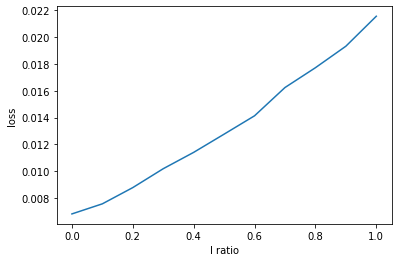

In [96]:
x = [i * 0.1 for i in range(11)]
y = losses
plt.plot(x, y)
plt.xlabel('l ratio')
plt.ylabel('loss')
plt.show()